## Random Forest Classifier

#### Global Libraries

In [132]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from os.path import isfile, join
import ast
import re
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#### Load the emotions.csv dataset

In [133]:
file = 'aj_data7.csv'
resume_flag = False
if isfile('ssl_emotions.csv'):
    file = 'ssl_emotions.csv'
    resume_flag = True
emotions = pd.read_csv(file, encoding='latin-1')
emotions.columns

Index(['Unnamed: 0', 'background', 'aeroplane', 'bicycle', 'bird', 'boat',
       'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
       'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
       'train', 'tv/monitor', 'red', 'n_red', 'yellow', 'n_yellow', 'green',
       'n_green', 'cyan', 'n_cyan', 'blue', 'n_blue', 'magenta', 'n_magenta',
       'emotion'],
      dtype='object')

### Export log functions

In [134]:
PRINT_SECONDS = 0
session_count = 0

def trackSession():
    global session_count
    if session_count == 0:
        session_count += 1
        return True
    else:
        return False
    return False

def setSession(file, flag=True):
    now = datetime.datetime.now()
    if flag:
        file.write("\n-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))
    else:
        file.write("-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))

def endSession(flag=True):
    now = datetime.datetime.now()
    if flag:
        return "\n-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    else:
        return "-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    return ""

def delayPrint(string, seconds, f="clf_logs.log"): # n seconds delay printing
    time.sleep(seconds)
    exportLogs(string, f)
    print(string)

def exportLogs(logs, f="clf_logs.log"):
    logs += "\n"
    if(isfile(f)):
        file = open(f, "a")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()
    else:
        print("Log file does not exist!")
        print("Creating {} file...".format(f))
        file = open(f, "a+")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()

### Save data functions

In [135]:
def initCtr(iter_file="iteration_counter.txt"):
    delayPrint("Checking {} file if empty...".format(iter_file), PRINT_SECONDS)
    with open(iter_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(iter_file), PRINT_SECONDS)
            file.write("0")
            delayPrint("Done initializing {}".format(iter_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(iter_file), PRINT_SECONDS)

def initTimeData(time_labels, time_file="time.txt"):
    delayPrint("Checking {} file if empty...".format(time_file), PRINT_SECONDS)
    with open(time_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(time_file), PRINT_SECONDS)
            for x in time_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(time_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(time_file), PRINT_SECONDS)

# load time.txt file for resuming purposes
def getTimeData(time_file="time.txt"):
    time_labels = []
    time_data = []
    with open(time_file, "r+") as file:
        delayPrint("Reading {} file...".format(time_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            time_label = dt[0]
            time_dt = ast.literal_eval(dt[len(dt) - 1])
            time_labels.append(time_label)
            time_data.append(time_dt)
            delayPrint("Fetched {} list...".format(time_label), PRINT_SECONDS)
    return time_labels, time_data

def saveTimeData(time_labels, time_data, time_file="time.txt"):
    with open(time_file, "w+") as file:
        print("Time Labels: {} Time Data: {}".format(time_labels, time_data))
        if len(time_labels) == len(time_data):
            for x in range(len(time_labels)):
                delayPrint("Saving time data...", PRINT_SECONDS)
                file.write("{} : {}\n".format(time_labels[x], time_data[x]))
            delayPrint("Saved time data...", PRINT_SECONDS)

def initScores(score_labels, score_file="scores.txt"):
    delayPrint("Checking {} file if empty...".format(score_file), PRINT_SECONDS)
    with open(score_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(score_file), PRINT_SECONDS)
            for x in score_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(score_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(score_file), PRINT_SECONDS)

# load scores.txt file for resuming purposes
def getScores(score_file="scores.txt"):
    score_labels = []
    scores = []
    with open(score_file, "r+") as file:
        delayPrint("Reading {} file...".format(score_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            score_label = dt[0]
            score = ast.literal_eval(dt[len(dt) - 1])
            score_labels.append(score_label)
            scores.append(score)
            delayPrint("Fetched {} list...".format(score_label), PRINT_SECONDS)
    return score_labels, scores

def saveScores(score_labels, scores, score_file="scores.txt"):
    with open(score_file, "w+") as file:
        print("Score Labels: {} Scores: {}".format(score_labels, scores))
        if len(score_labels) == len(scores):
            for x in range(len(score_labels)):
                delayPrint("Saving scores...", PRINT_SECONDS)
                file.write("{} : {}\n".format(score_labels[x], scores[x]))
            delayPrint("Saved scores...", PRINT_SECONDS)

#### Remove filename column and change column headers

In [136]:
if not resume_flag:
    emotions = emotions.drop('filename', axis=1)
    emotions.columns = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
           'train', 'tv/monitor', 'red', 'n_red', 'yellow',
           'n_yellow', 'green', 'n_green', 'cyan',
           'n_cyan', 'blue', 'n_blue', 'magenta',
           'n_magenta', 'emotion']
else:
    emotions = emotions.drop("Unnamed: 0", axis=1)
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Show dataframe

In [137]:
# emotions = emotions[:616]
# emotions = emotions[:30]
# emotions['emotion'][100:len(emotions)] = np.nan
# emotions_c = pd.DataFrame()
emotions_c = emotions.copy()
emotions_c['emotion'] = ""
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Drop rows with NaN values and segregate initial dataframes with labeled and unlabeled data

In [138]:
emotions_labeled = emotions.dropna()

# fix wrong spelling
emotions_labeled = emotions_labeled.replace(["aniticipation"], "anticipation")
# emotions_labeled.at[0, 'emotion'] = "joy"
# emotions_labeled.at[1, 'emotion'] = "joy"
# emotions_labeled.at[3, 'emotion'] = "anger"
# emotions_labeled.at[5, 'emotion'] = "disgust"
# emotions_labeled.at[6, 'emotion'] = "surprise"
# emotions_labeled.at[8, 'emotion'] = "trust"
# emotions_labeled.at[9, 'emotion'] = "trust"
# emotions_labeled.at[13, 'emotion'] = "disgust"
emotions_labeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.000000,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


In [139]:
# replace NaN values with empty string
# reference: https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
emotions_unlabeled = emotions.replace([np.nan], "")
emotions_unlabeled = emotions_unlabeled.drop(emotions_unlabeled[emotions_unlabeled['emotion'] != ""].index)

# adjust indices for the unlabeled set
emotions_unlabeled.index = range(len(emotions_unlabeled.index))
emotions_unlabeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.000000,0,0.000000,0,0.000109,1,0.008218,3,
1,0.950860,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.012509,5,0.029428,8,0.000008,1,0.005586,7,
2,0.885321,0.000000,0.000000,0.000000,0.000000,0.002242,0.0,0.0,0.000000,0.000000,...,5,0.454127,5,0.208709,11,0.000000,0,0.032067,7,
3,0.897058,0.002579,0.000000,0.000000,0.045458,0.000000,0.0,0.0,0.000000,0.004916,...,7,0.180195,3,0.177174,6,0.001316,3,0.033679,7,
4,0.790539,0.000000,0.000000,0.000000,0.209461,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.007162,7,0.128355,7,0.001260,1,0.068531,7,
5,0.848834,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.235004,6,0.053108,5,0.000583,1,0.019425,3,
6,0.964508,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000222,0.000000,...,5,0.771270,7,0.067746,8,0.000048,1,0.001619,6,
7,0.982182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.000000,0,0.000000,0,0.000000,0,0.057497,3,
8,0.923988,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,6,0.109810,5,0.218994,7,0.001583,3,0.129065,6,
9,0.960269,0.000000,0.000000,0.000000,0.036473,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.216980,7,0.374303,10,0.000025,1,0.016920,6,


#### Set data X and target y for the labeled data and the unlabeled data

In [140]:
X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
y_labeled

0                joy
1                joy
2            sadness
3                joy
4                joy
5                joy
6                joy
7          AMBIGUOUS
8          AMBIGUOUS
9          AMBIGUOUS
10           disgust
11               joy
12              fear
13               joy
14               joy
15           sadness
16               joy
17               joy
18              fear
19               joy
20               joy
21         AMBIGUOUS
22               joy
23               joy
24               joy
25           sadness
26           sadness
27               joy
28               joy
29              fear
            ...     
2889         sadness
2890         sadness
2891             joy
2892        surprise
2893         disgust
2894           anger
2895           anger
2896        surprise
2897         disgust
2898         sadness
2899    anticipation
2900             joy
2901    anticipation
2902    anticipation
2903         disgust
2904         disgust
2905         

#### Split the dataset into training and test sets

In [141]:
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)

#### Whole process of constructing labeled data from predicted labels (Semi-supervised learning)

Checking time.txt file if empty...
time.txt not empty...
Reading time.txt file...
Fetched Elapsed Time Iteration  list...
Fetched Time Passed  list...
Checking scores.txt file if empty...
scores.txt not empty...
Reading scores.txt file...
Fetched Best Test Scores  list...
Fetched Best Cross-Validation Scores  list...
Fetched Out-of-bag Scores  list...


-------------------- SESSION - 2018-09-27 15:51 -------------------------

Checking time.txt file if empty...

Initializing time.txt file...

Done initializing time.txt

Reading time.txt file...

Fetched Elapsed Time Iteration list...

Fetched Time Passed list...

Checking scores.txt file if empty...

Initializing scores.txt file...

Done initializing scores.txt

Reading scores.txt file...

Fetched Best Test Scores list...

Fetched Best Cross-Validation Scores list...

Fetched Out-of-bag Scores list...

---------- Start Time - 2018-09-27 15:51:33.588810 ----------

Total number of models: 7620

Checking iteration_counter.txt file if emp

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Current number of models: 4440
Remaining number of models: -1080
Loading ssl gs model...
Saving gs model...
Loading model...
Saving model...
Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.933

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.96
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

/home/butchersix/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

Test set score: 0.95
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.31
Out-of-Bag Prediction Score: 0.23
Score Labels: ['Best Test Scores ', 'Best Cross-Validation Scores ', 'Out-of-bag Scores '] Scores: [[0.15151515151515152, 0.56, 0.6515151515151515, 0.7423312883435583, 0.8177083333333334, 0.8590909090909091, 0.8780487804878049, 0.8929889298892989, 0.8779661016949153, 0.8962264150943396, 0.8997050147492626, 0.9055555555555556, 0.9050131926121372, 0.9045226130653267, 0.8963855421686747, 0.9027777777777778, 0.9107142857142857, 0.9028077753779697, 0.9119496855345912, 0.9124236252545825, 0.9145129224652088, 0.9205426356589147, 0.920303605313093, 0.9256505576208178, 0.930783242258652, 0.9338103756708408, 0.9366197183098591, 0.9393414211438474, 0.9419795221843004, 0.9478114478114478, 0.9517470881863561, 0.9523809523809523, 0.9512

elapsed_time_iter_list: ['0:04:38.570191', '0:00:01.731791', '0:00:01.729469', '0:00:01.627041', '0:00:01.602656', '0:00:01.494950', '0:00:01.523058', '0:00:01.410732', '0:00:01.446550', '0:00:01.332391', '0:00:01.336685', '0:00:01.343406', '0:00:01.239403', '0:00:01.224202', '0:00:01.197234', '0:00:01.217763', '0:00:01.128468', '0:00:01.102590', '0:00:01.083830', '0:00:01.127044', '0:00:01.046211', '0:00:01.021957', '0:00:01.016024', '0:00:01.053959', '0:00:00.954114', '0:00:00.958228', '0:00:00.925969', '0:00:00.956875', '0:00:00.902908', '0:00:00.984283', '0:00:00.879671', '0:00:00.878661', '0:00:00.856811', '0:00:00.825327', '0:00:00.815420', '0:00:00.813265', '0:00:00.793216', '0:00:00.906255', '0:00:00.781808', '0:00:00.783532', '0:00:00.768444', '0:00:00.767671', '0:00:00.830235', '0:00:00.790315', '0:00:00.773458', '0:00:00.746444', '0:00:00.786155', '0:00:00.915967', '0:00:00.729060', '0:00:00.724501', '0:00:00.722138', '0:00:00.743356', '0:00:00.733132', '0:00:00.702620', '0:

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


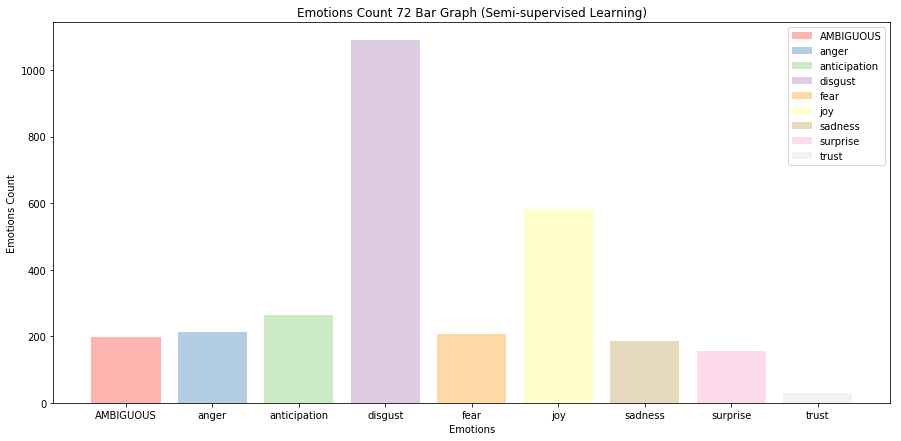

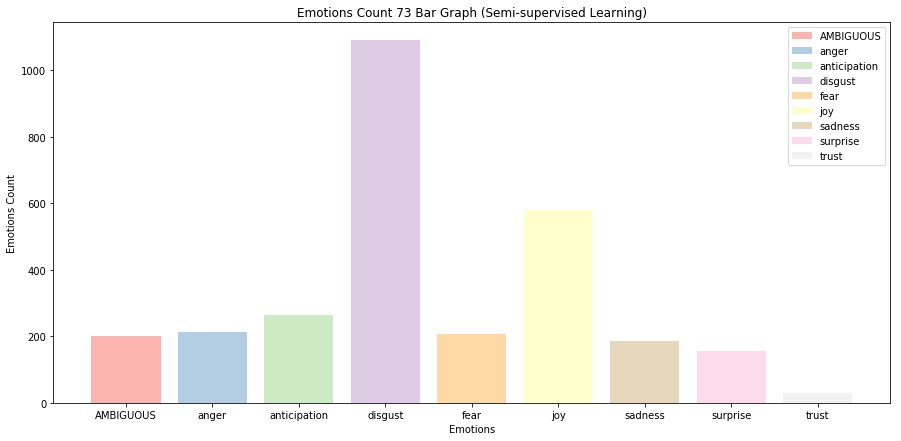

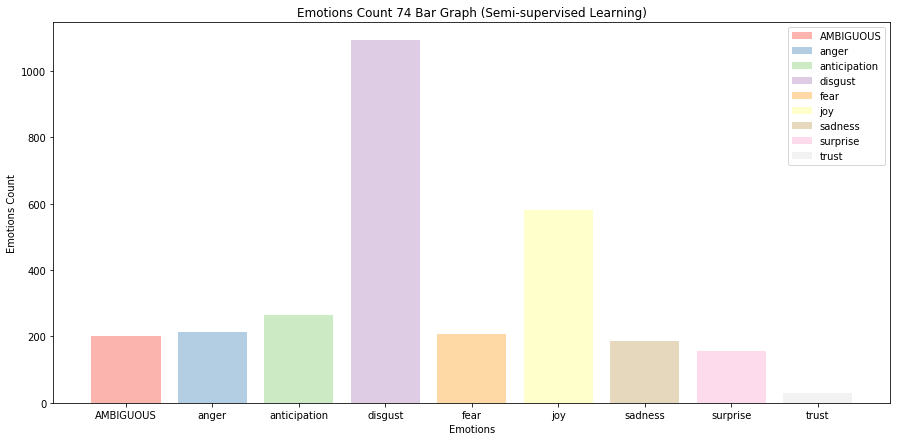

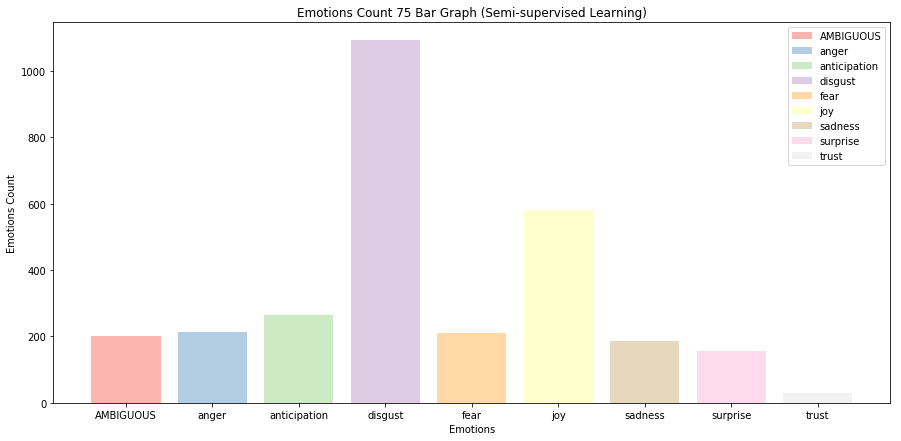

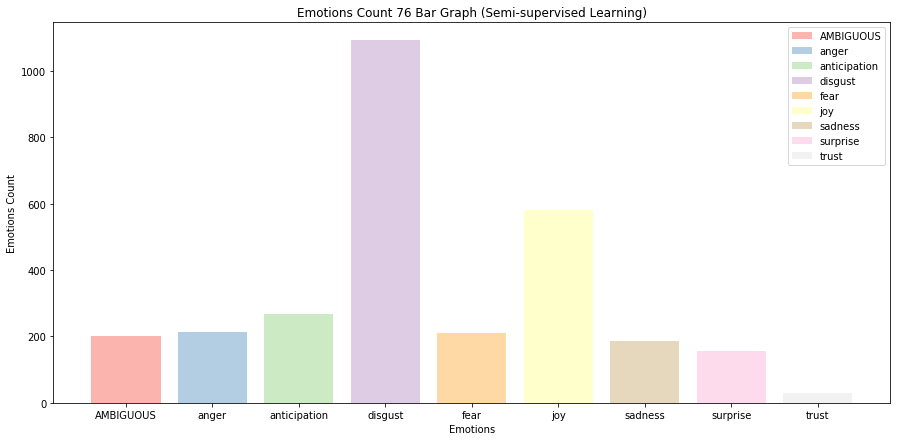

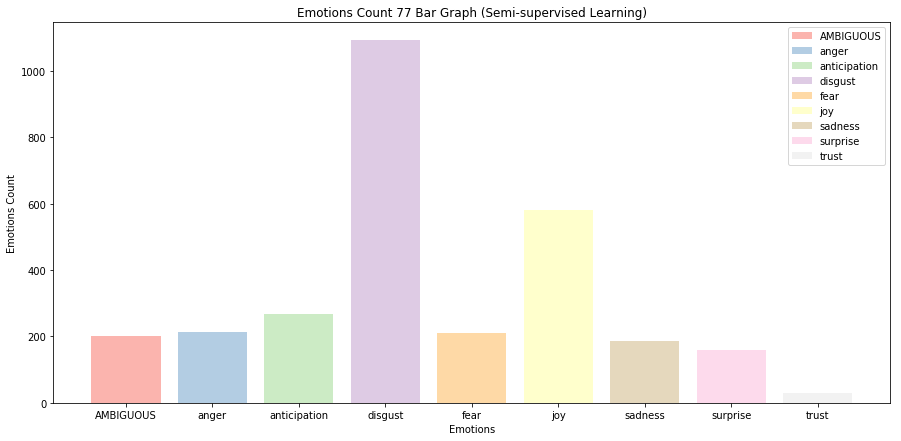

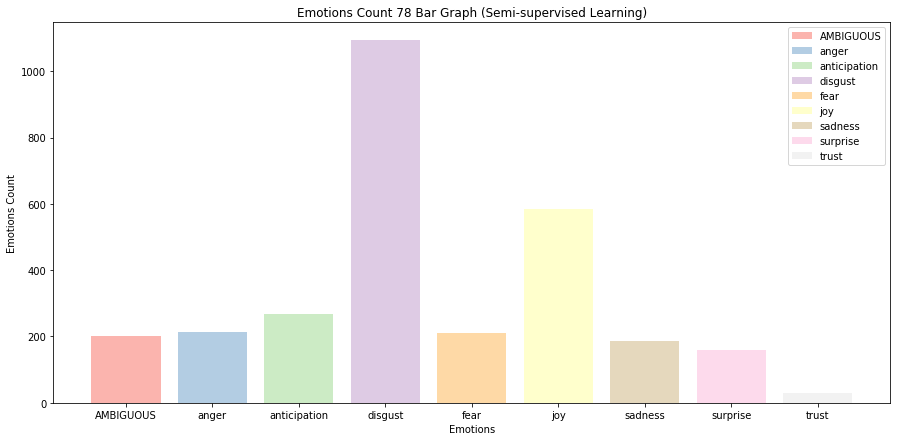

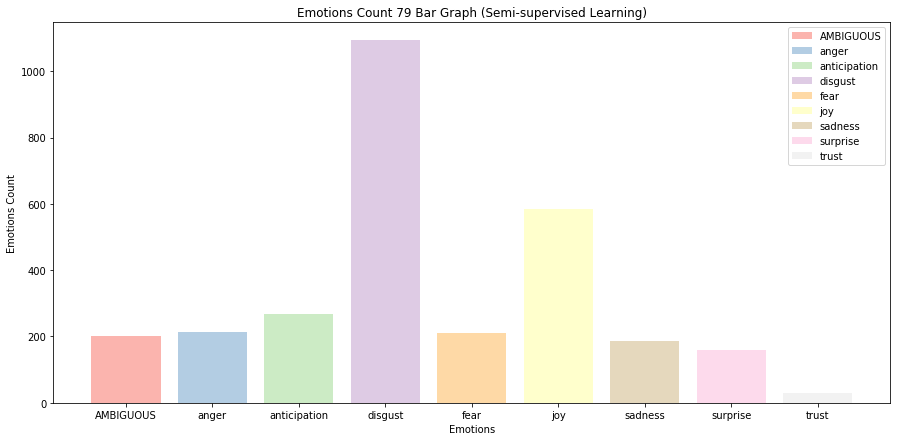

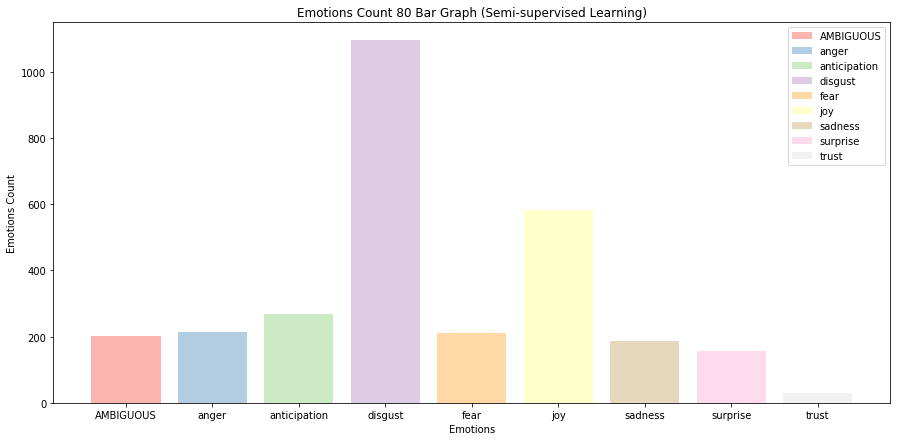

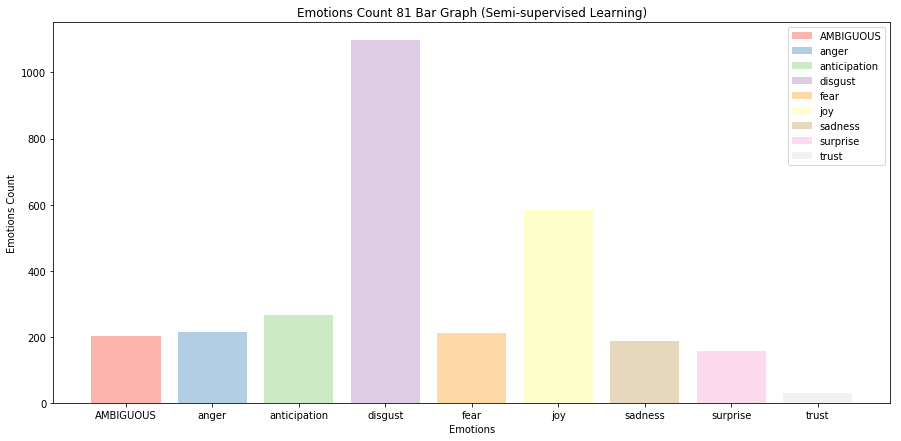

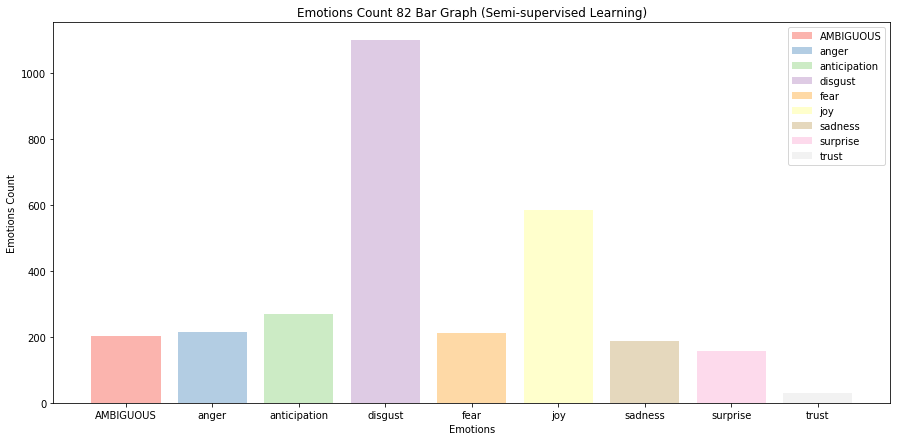

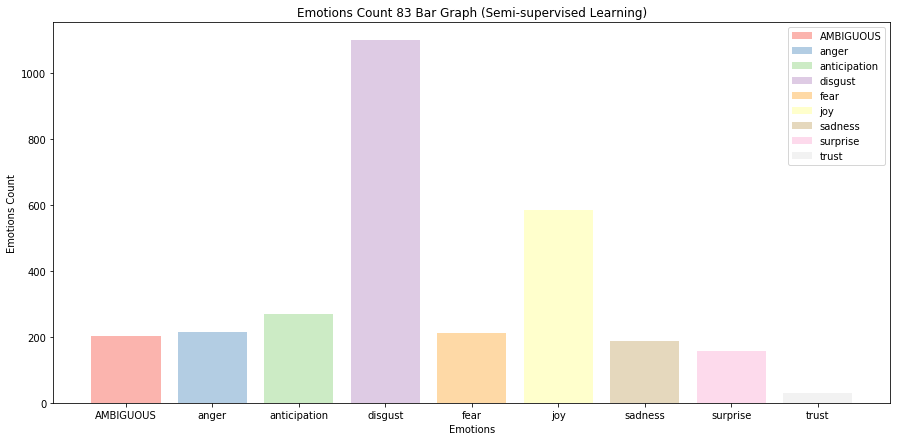

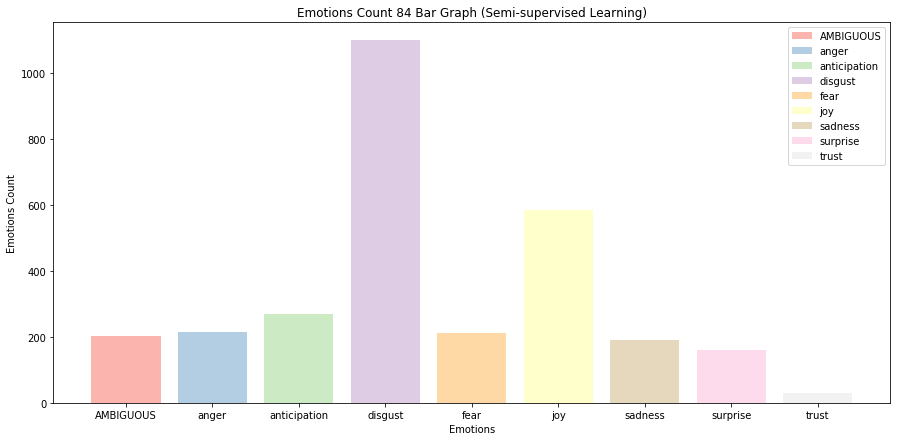

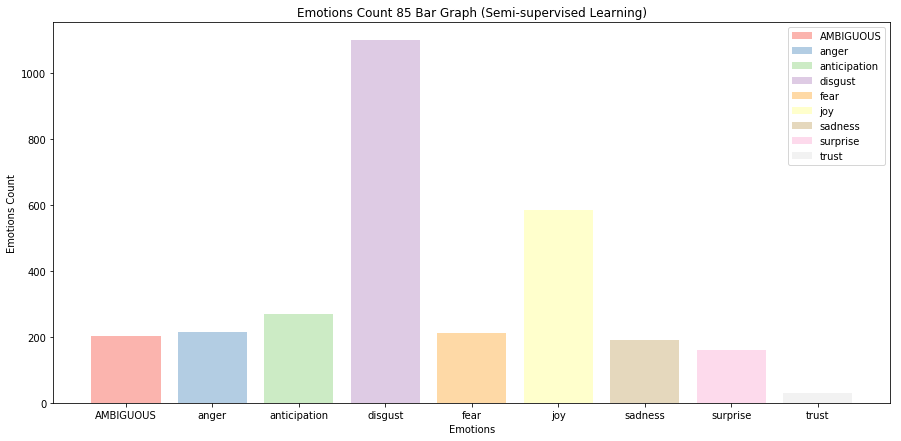

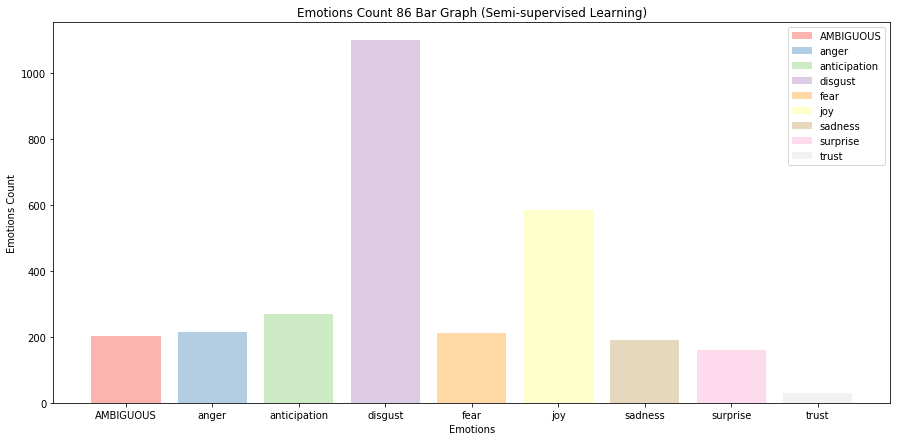

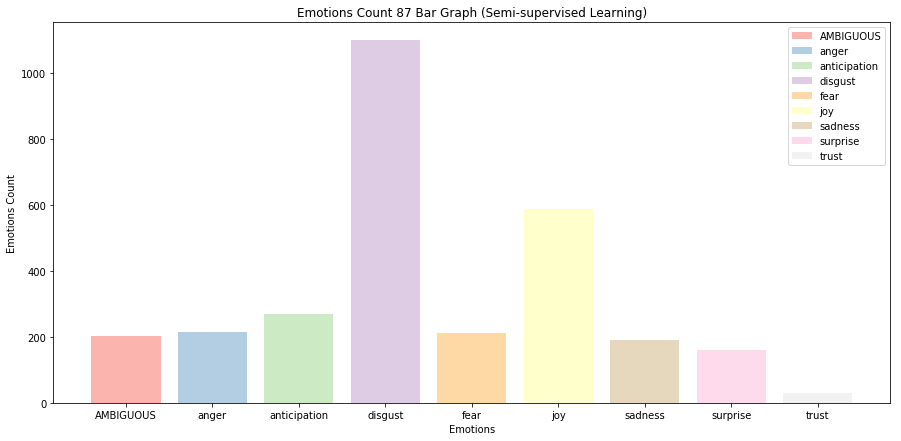

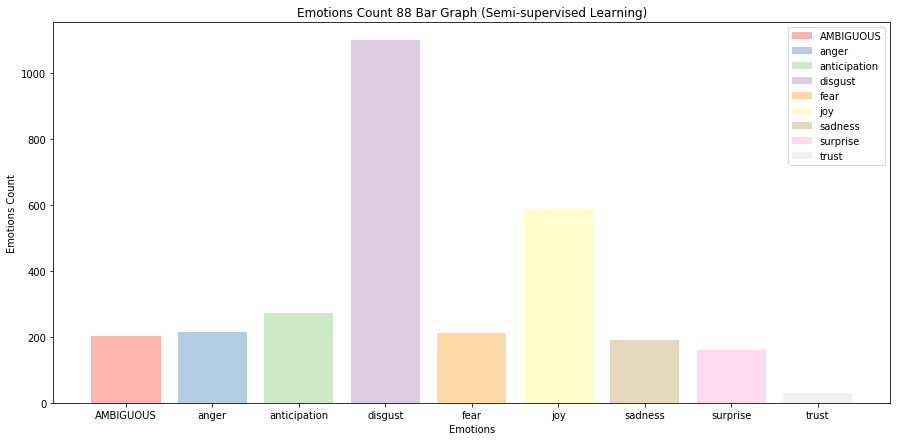

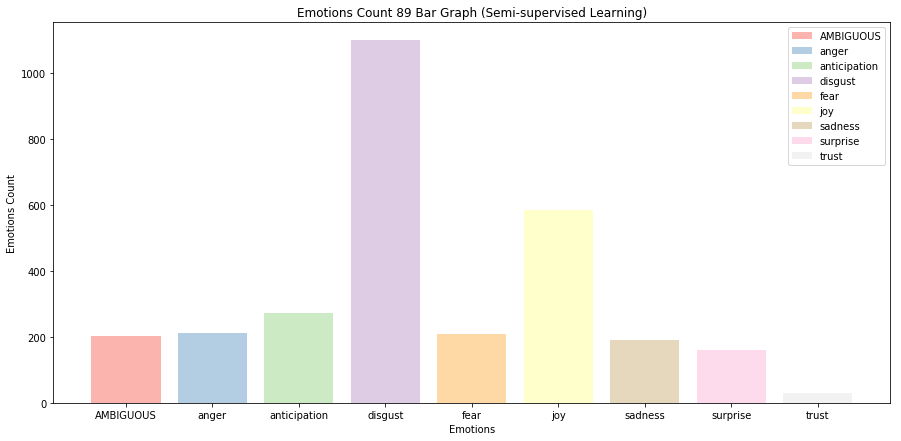

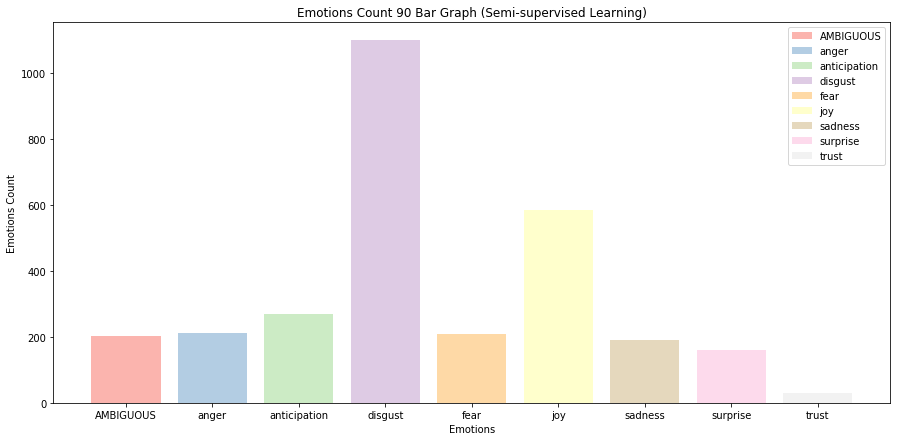

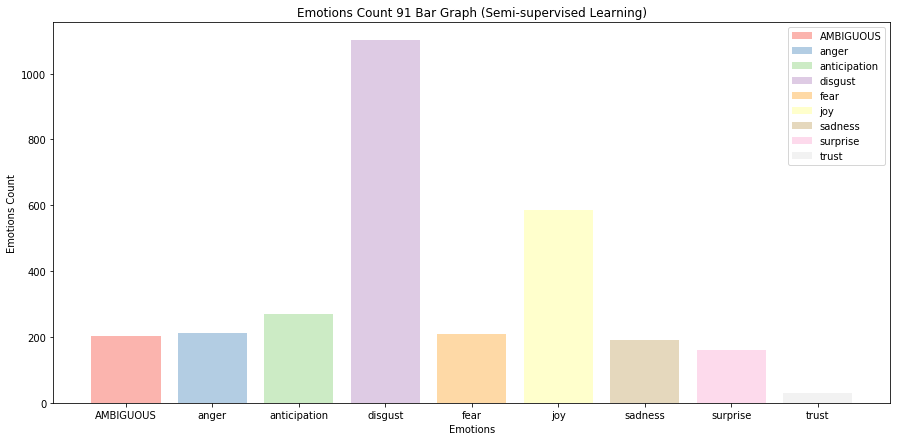

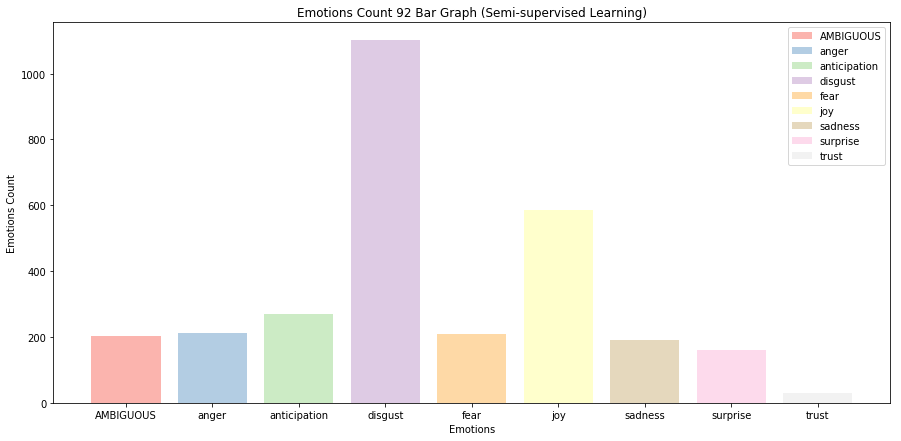

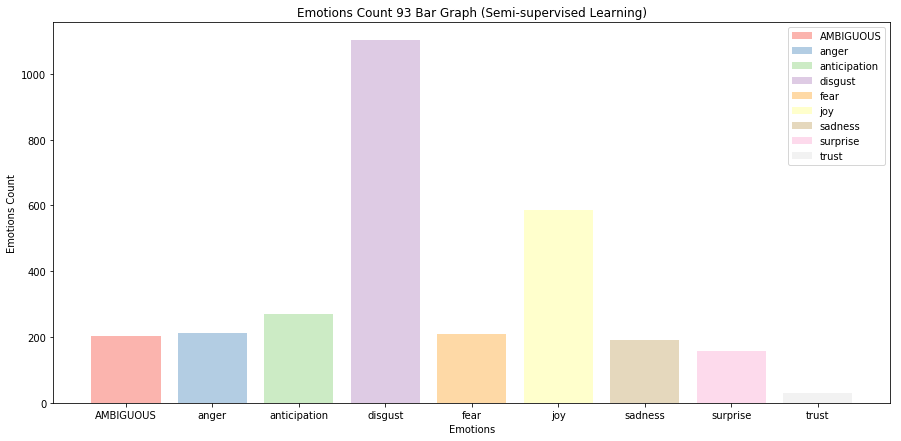

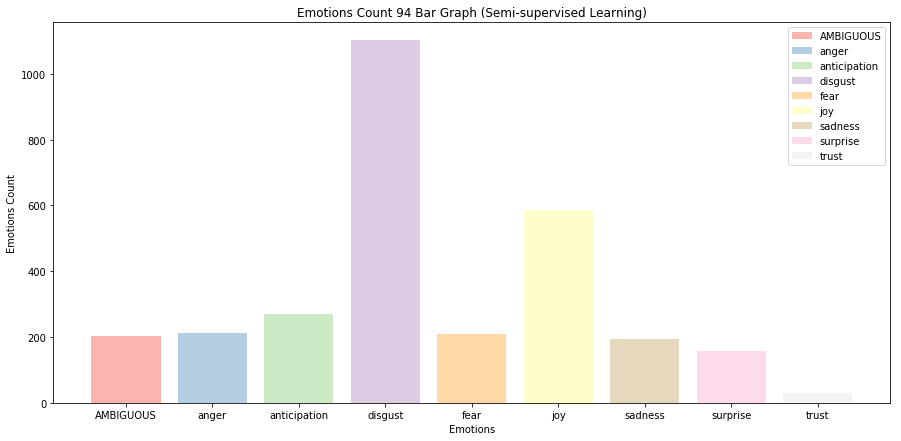

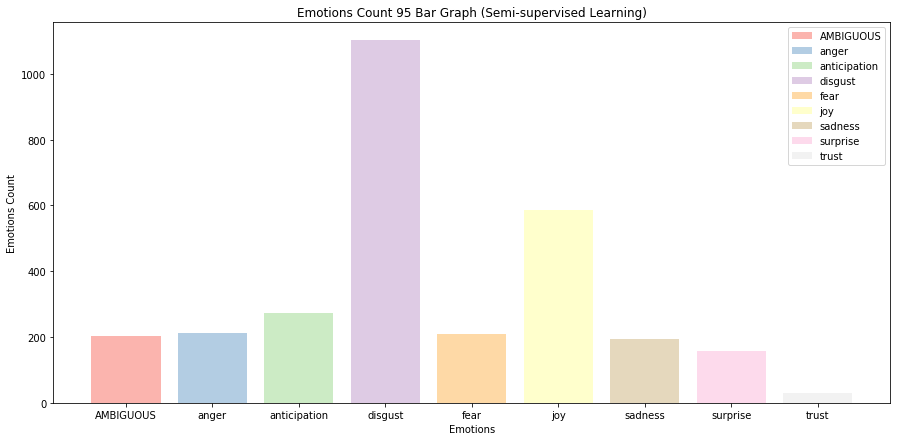

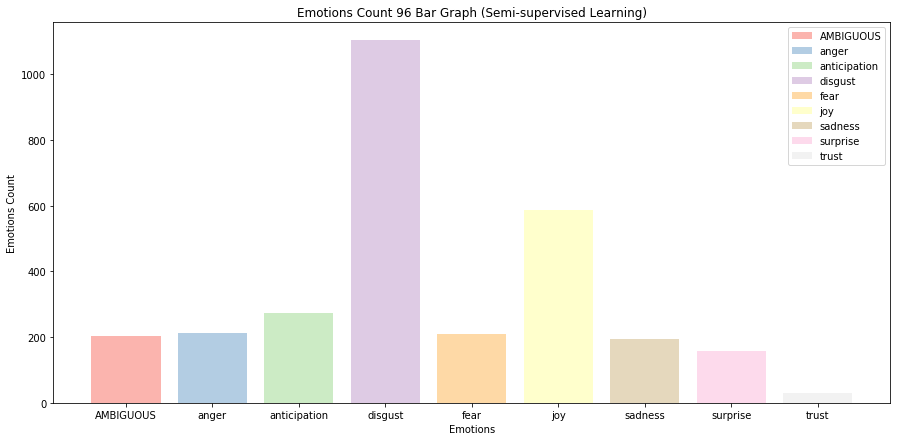

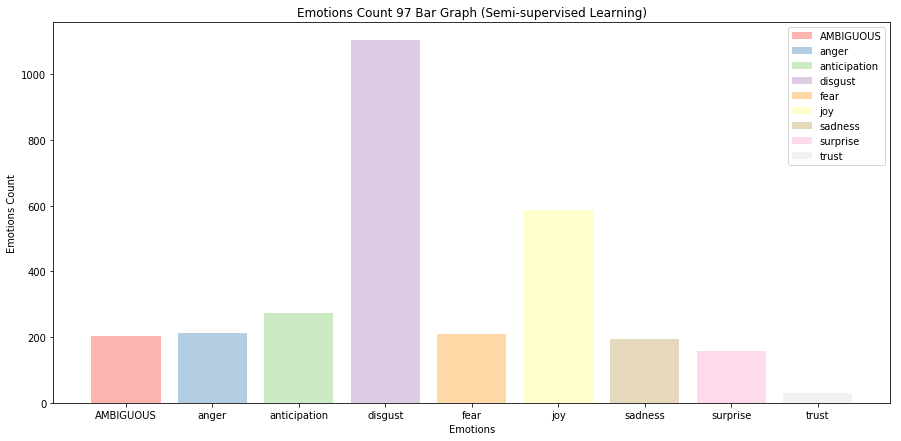

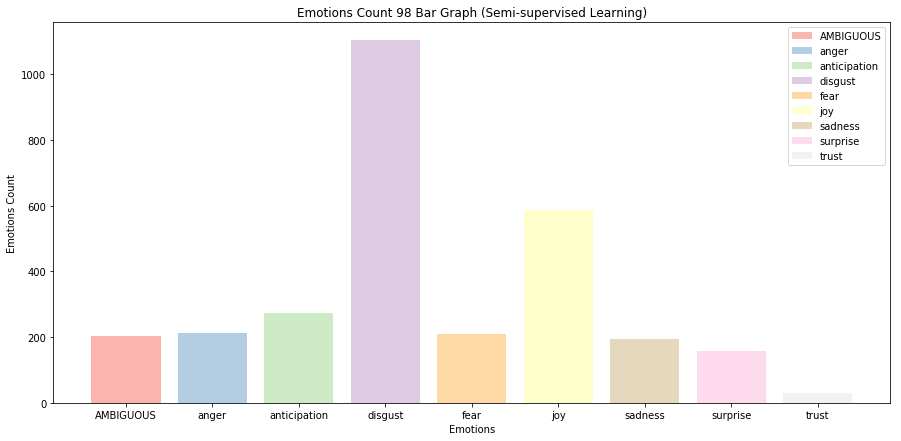

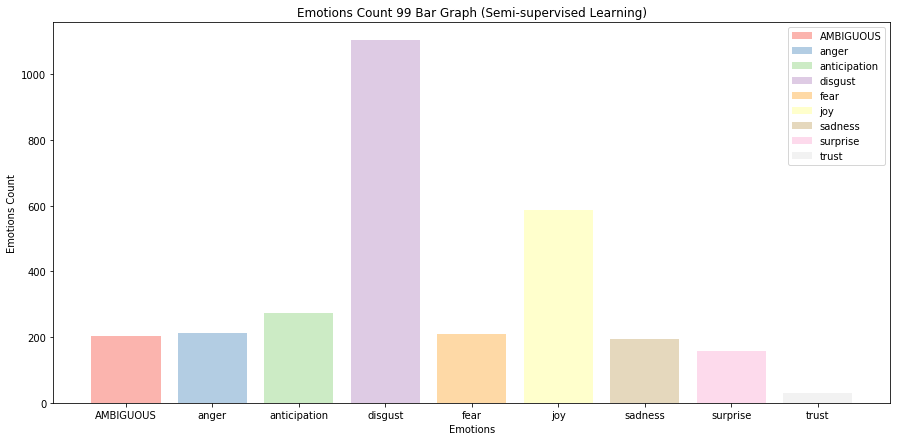

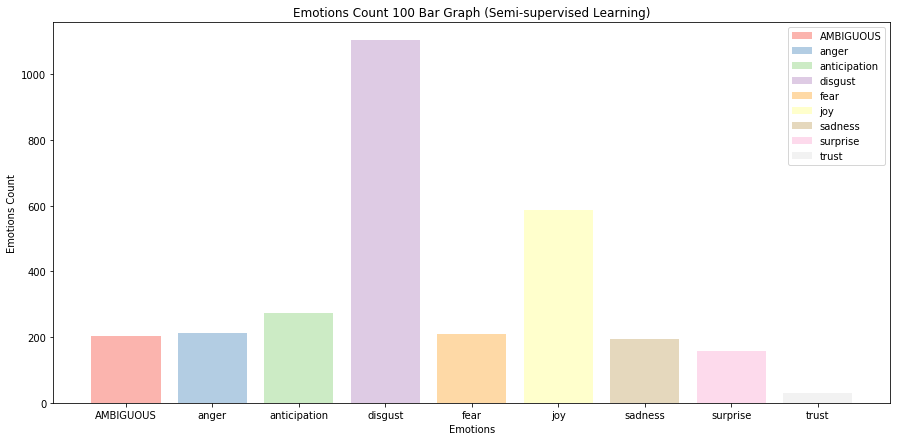

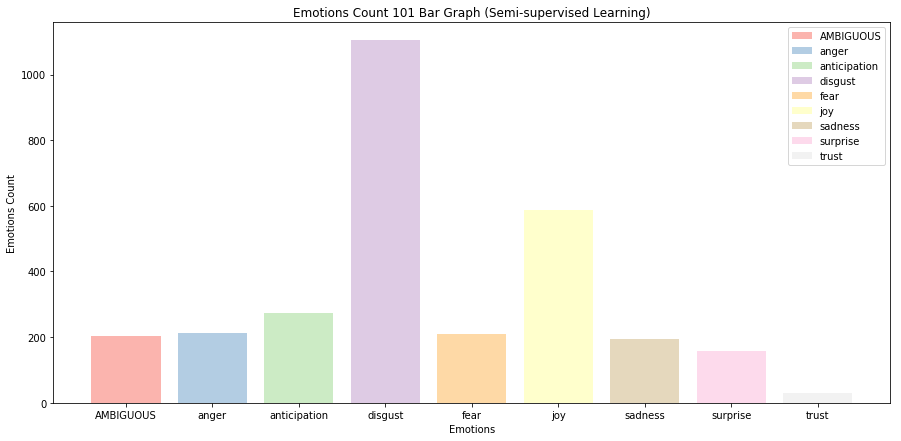

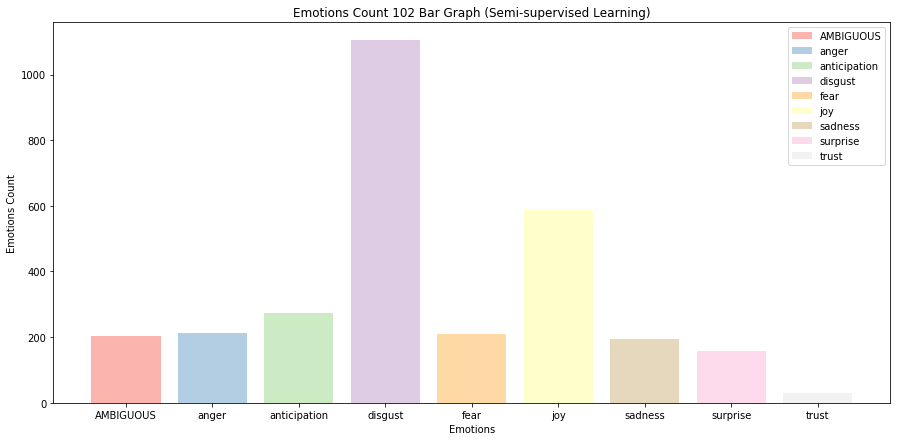

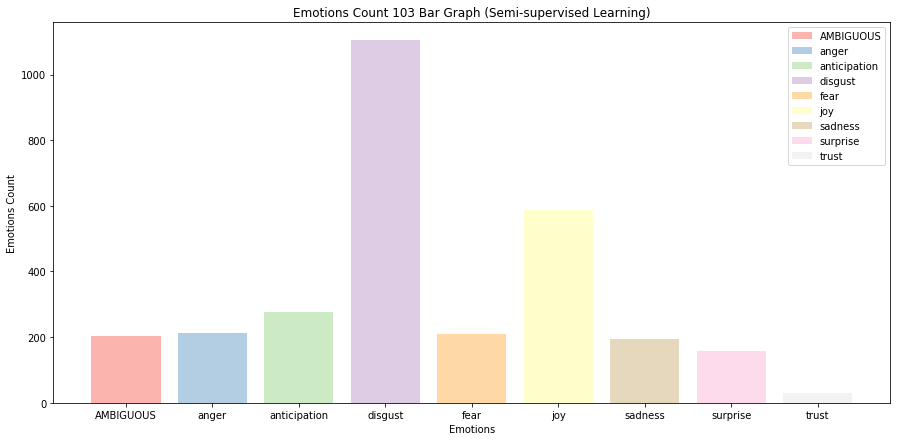

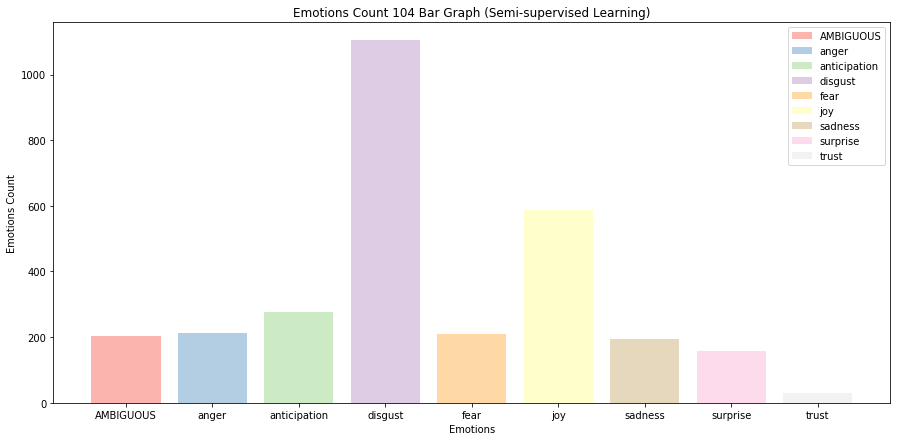

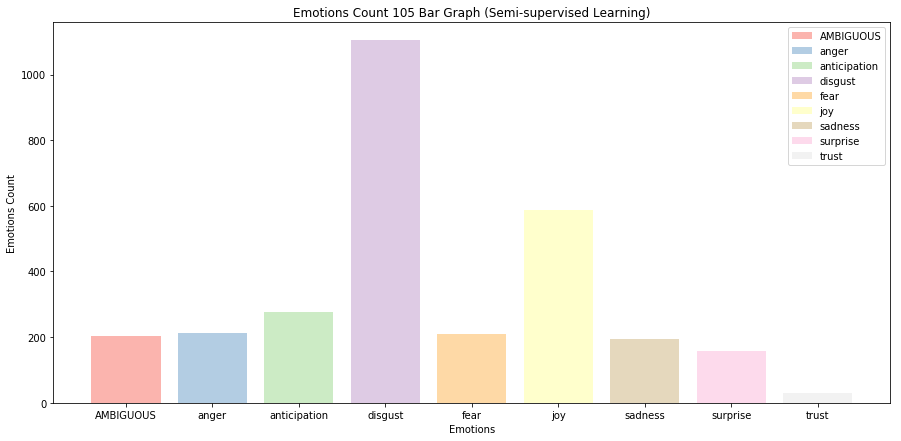

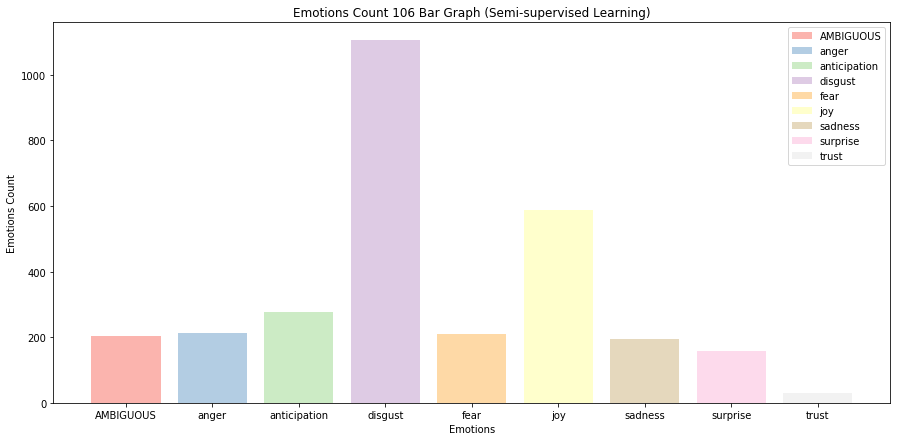

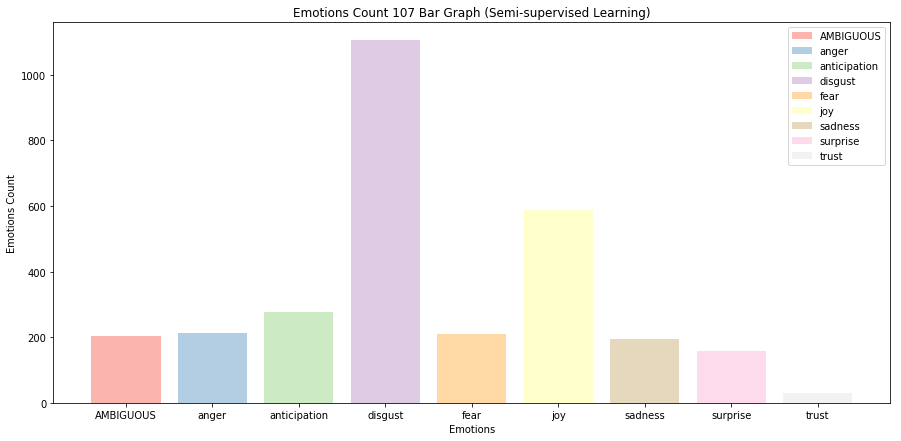

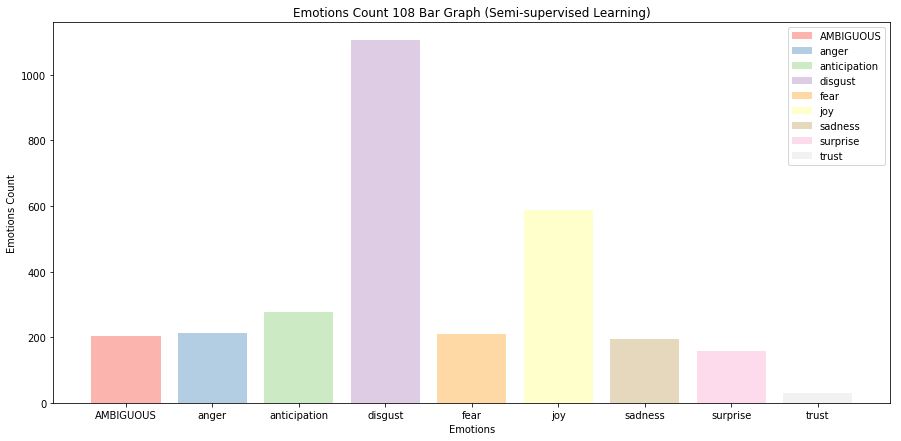

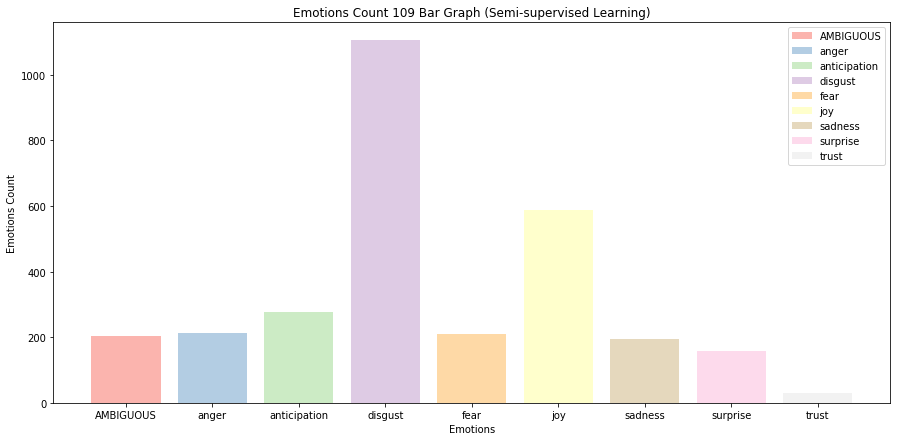

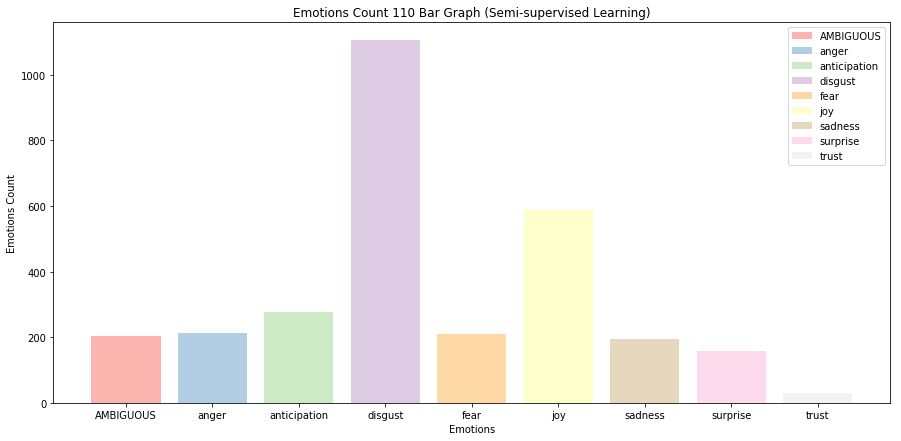

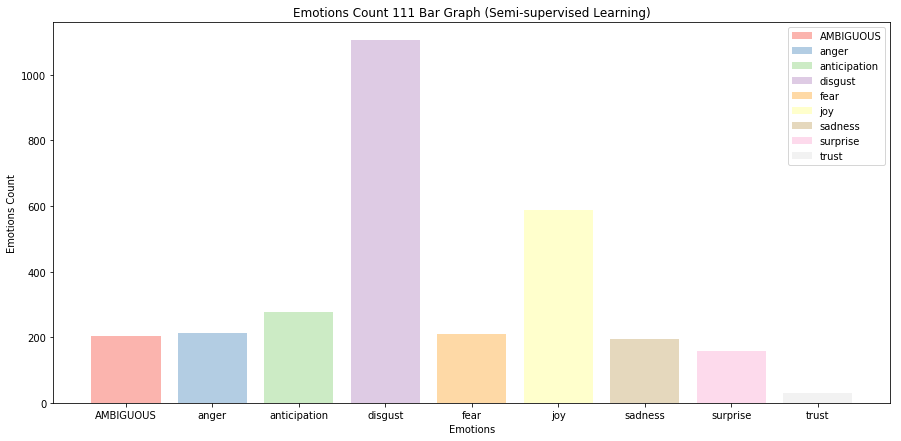

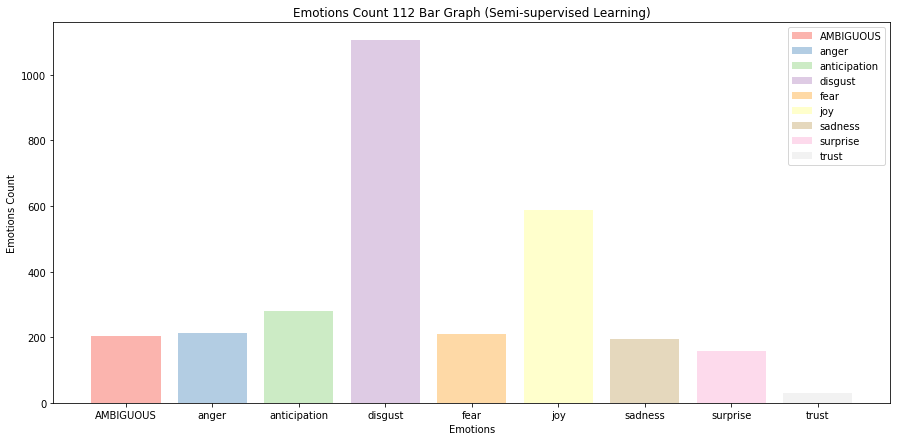

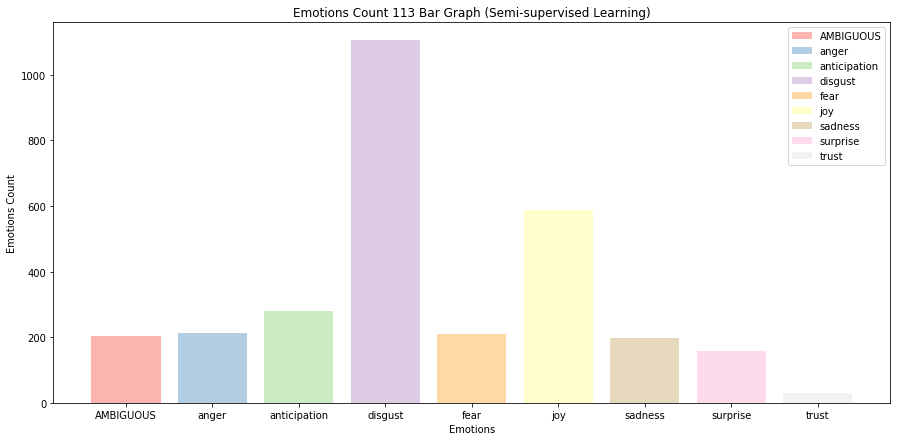

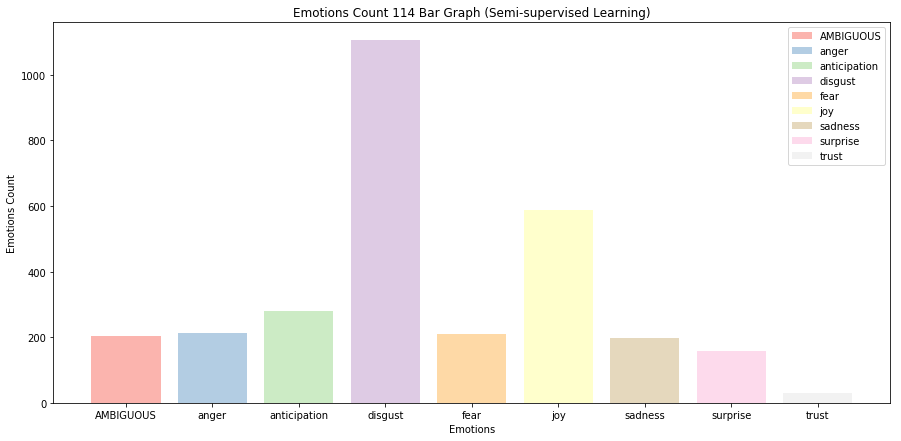

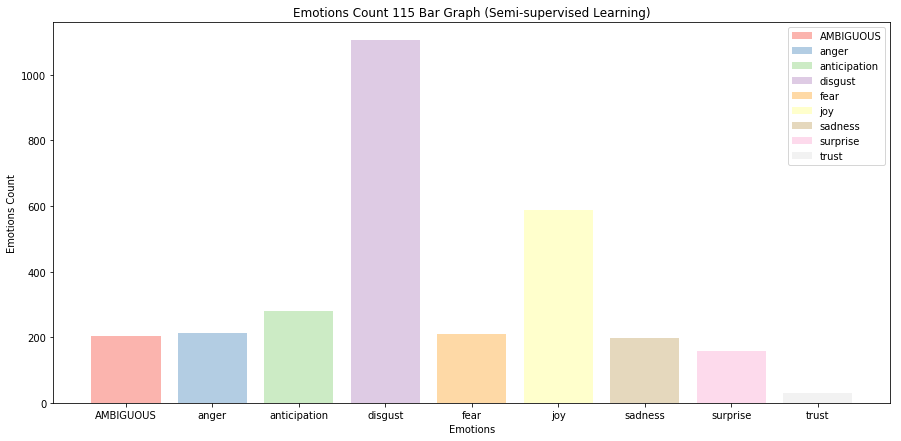

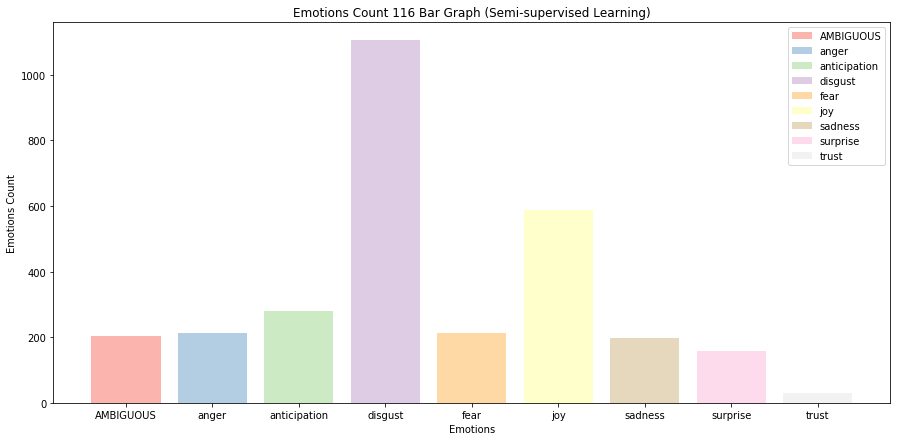

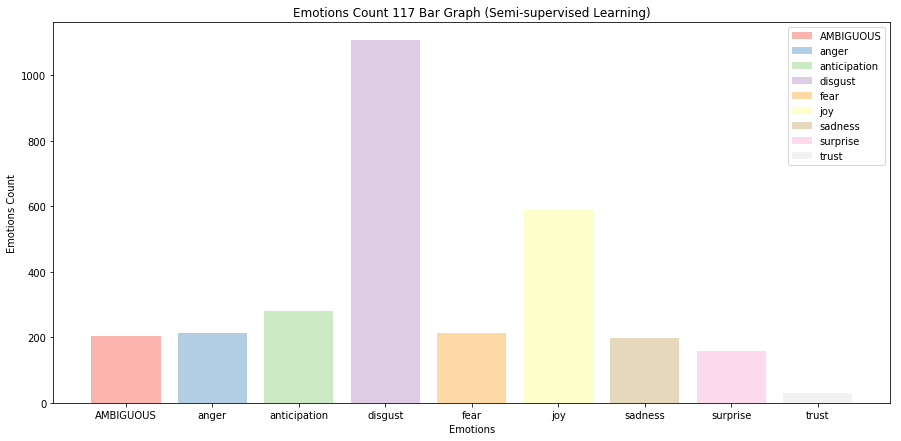

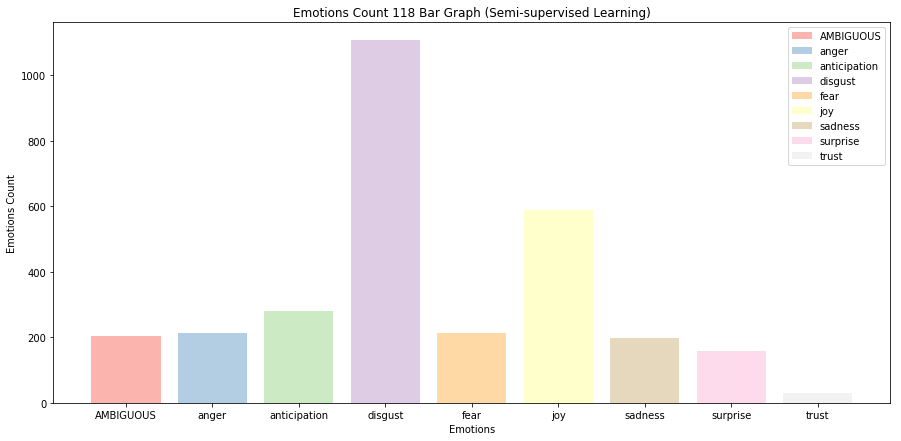

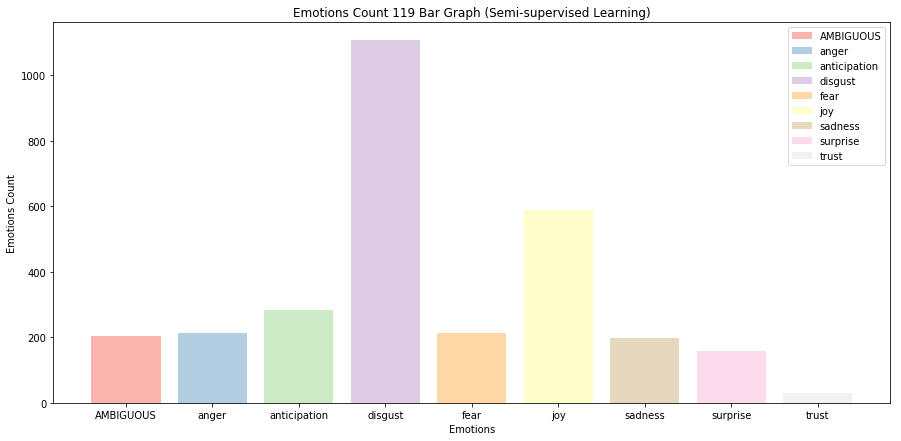

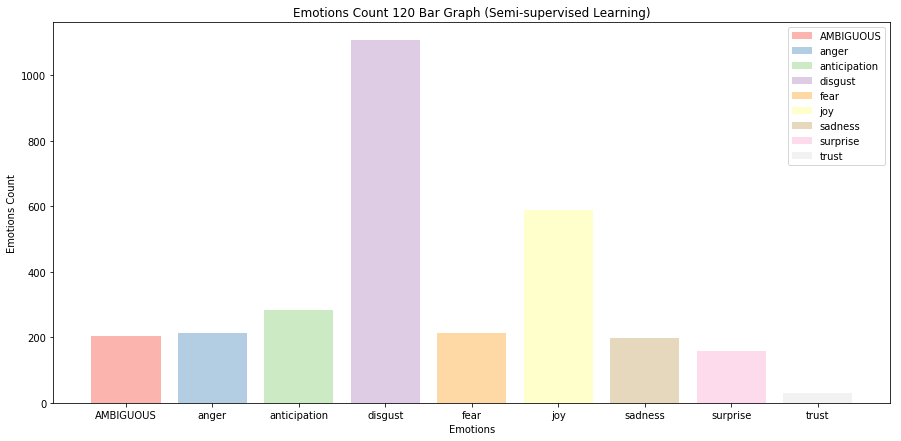

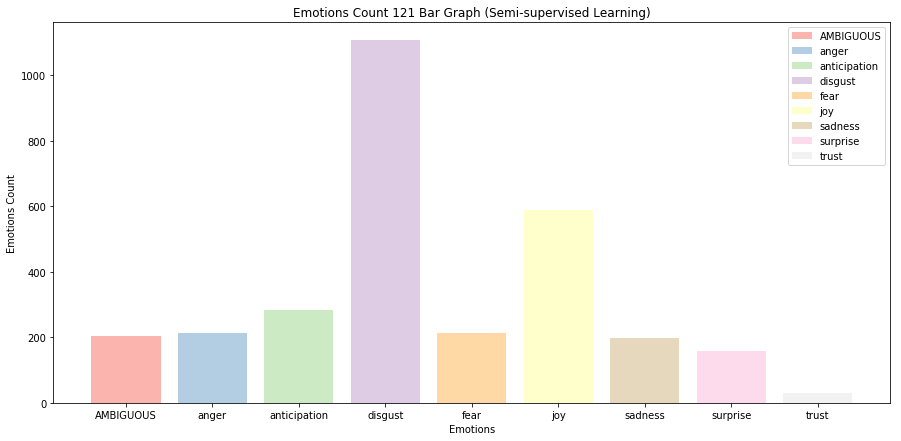

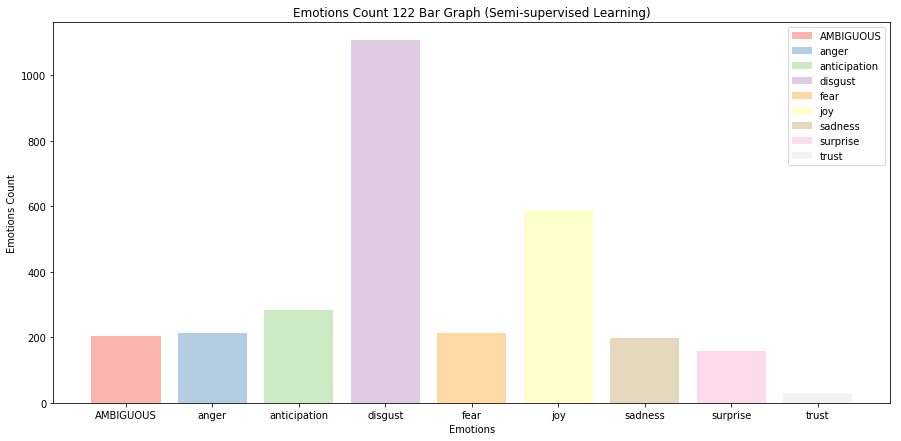

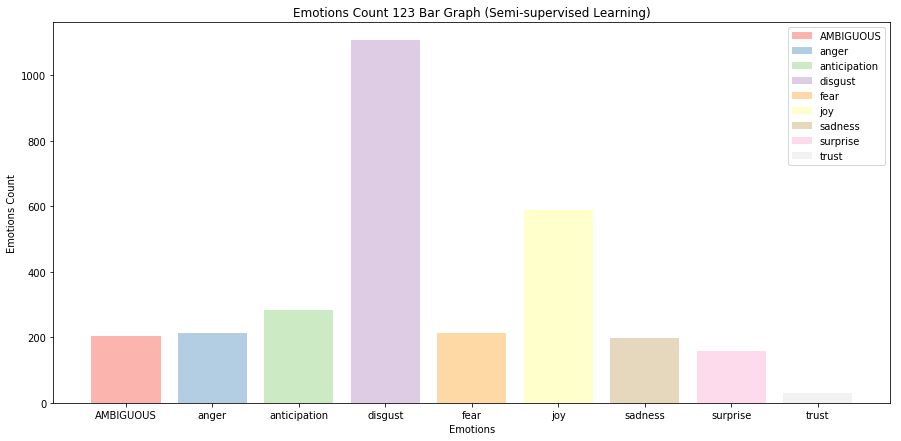

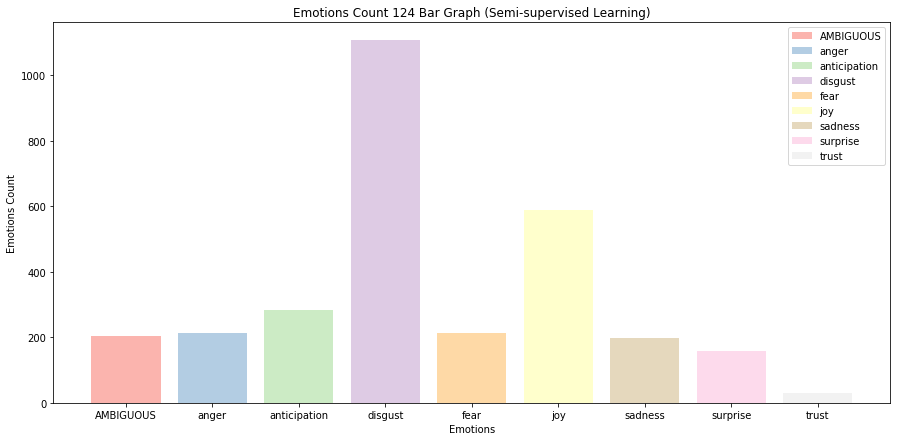

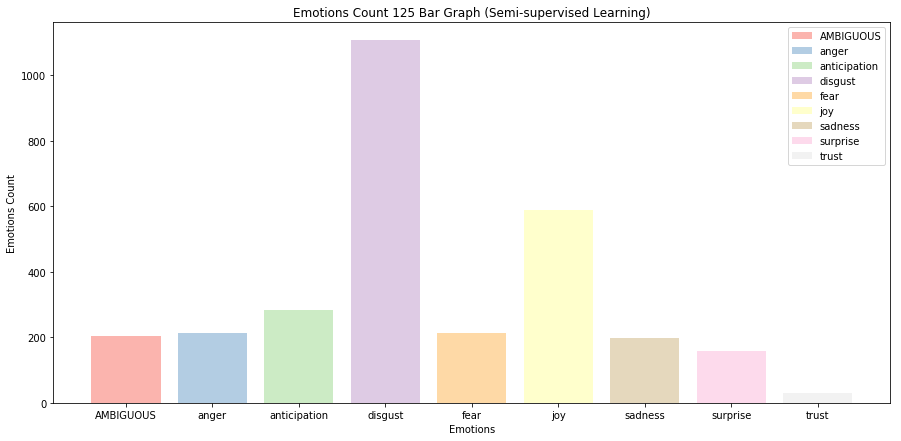

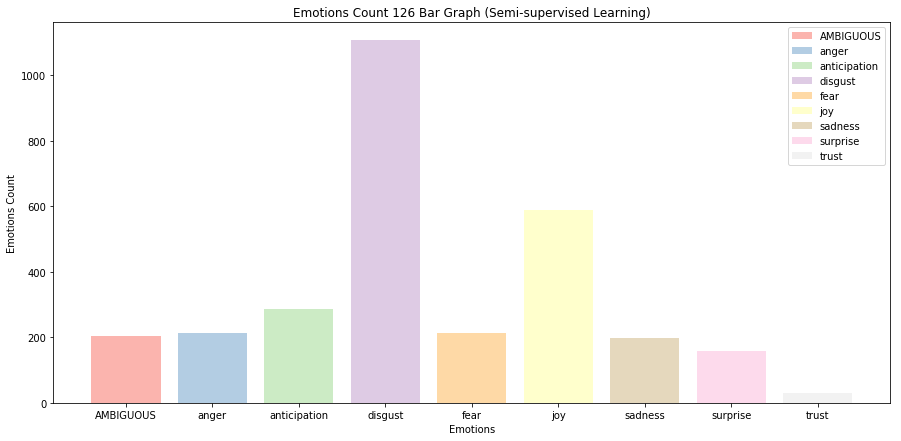

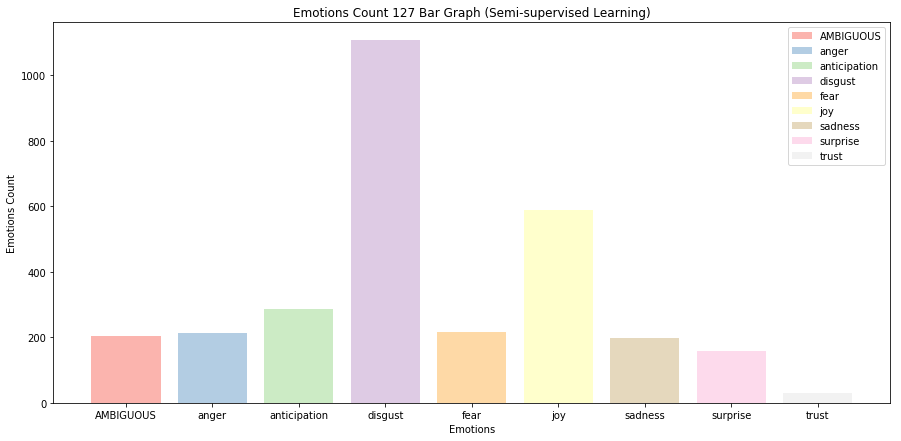

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
# only use first default hyperparameters for experimenting only

# set hyperparameters of classifier
param_grid = {'n_estimators' : [100, 200, 500],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}

# rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
# rfc = RandomForestClassifier(n_estimators=500,
#                              criterion='entropy',
#                              max_leaf_nodes=16,
#                              n_jobs=-1,
#                              random_state=0)

# flag for using only base hyperparameters for all iterations
isUseBaseParams = True

time_file = "time.txt"
scores_file = "scores.txt"

# time lists
time_labels = ["Elapsed Time Iteration", "Time Passed"]
initTimeData(time_labels)
time_labels, time_data = getTimeData(time_file)
elapsed_time_list = []
elapsed_time_iter_list = time_data[0]
time_passed_list = time_data[1]

# scores lists
score_labels = ["Best Test Scores", "Best Cross-Validation Scores", "Out-of-bag Scores"]
initScores(score_labels)
score_labels, scores = getScores(scores_file)
best_score_list = scores[0]
best_cross_val_score = scores[1]
oob_score_list = scores[2]

iteration_counter = 0
start_time = datetime.datetime.now()

# print previous session
log_file = "clf_logs.log"
if isfile(log_file):
    with open(log_file, "r+") as file:
        lines = file.readlines()
        for line in lines:
            print(line)
            
delayPrint("---------- Start Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)

# define threshold parameter
threshold = 0.05

# compute number of iterations produced
emotions_labeled_len = len(emotions_labeled)
emotions_unlabeled_len = len(emotions_unlabeled)
while(emotions_labeled_len < len(emotions)):
    iteration_counter += 1
    estimated_rows = 1 if int((threshold*emotions_unlabeled_len)) < 1 else int((threshold*emotions_unlabeled_len))
    emotions_labeled_len += estimated_rows
    emotions_unlabeled_len -= estimated_rows

# show total number of models
num_models_settings = 1
for k, v in param_grid.items():
    num_models_settings *= len(v)
total_num_models = iteration_counter * num_models_settings
delayPrint("Total number of models: {}".format(total_num_models), PRINT_SECONDS)

# set default iteration_counter
iteration_counter_file = "iteration_counter.txt"
initCtr()
    
# check saved interation_counter
with open(iteration_counter_file, "r+") as file:
    data = file.readlines()
    iteration_counter = int(data[0])
    
# loop if not all target values have emotions
# loop until everything is labeled
while(emotions['emotion'].isnull().values.any()):
    start_time_iter = datetime.datetime.now()
    
    # check saved interation_counter
    with open(iteration_counter_file, "r+") as file:
        data = file.readlines()
        iteration_counter = int(data[0])
    
    # show remaining number of models to produce
    num_models_current_settings = 1
    for k, v in param_grid.items():
        num_models_current_settings *= len(v)
    current_num_models = iteration_counter * num_models_current_settings
    rem_num_models = total_num_models - current_num_models
    delayPrint("Current number of models: {}".format(current_num_models), PRINT_SECONDS)
    delayPrint("Remaining number of models: {}".format(rem_num_models), PRINT_SECONDS)
    
    # incrementing iteration_counter
    iteration_counter += 1
        
    # grid search for random forest with 2 standard cross-validation
    # original cross-validation = 10
    model_file = 'ssl_rf_{}.pickle'.format(threshold*100) # model file name according to threshold percentage
    gs_file = 'ssl_gs_rf_{}.pickle'.format(threshold*100)
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
    if isfile(gs_file):
        delayPrint("Loading ssl gs model...", PRINT_SECONDS)
        grid_search = pickle.load(open(gs_file, 'rb'))
        best_params = grid_search.best_params_
    elif not isfile(gs_file) or not isUseBaseParams:
        delayPrint("Doing grid search...", PRINT_SECONDS)
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
        grid_search.fit(X_train_labeled, y_train_labeled)
        best_params = grid_search.best_params_
    
    # saving grid search model
    with open(gs_file, 'wb') as file:
        delayPrint("Saving gs model...", PRINT_SECONDS)
        pickle.dump(grid_search, file)
    
    # use saved model if there is
    rfc = RandomForestClassifier()
    if isfile(model_file):
        delayPrint("Loading model...", PRINT_SECONDS)
        rfc = pickle.load(open(model_file, 'rb'))
    elif not isfile(model_file) or not isUseBaseParams: # else-if for using only best base hyperparameters
        # comment else and unindent block to get best hyperparameters in each iteration
        # set best base parameters
        delayPrint("Using best hyperparameters...", PRINT_SECONDS)
        rfc.set_params(**best_params)

        # train the classifier
        rfc.fit(X_train_labeled, y_train_labeled)
    
    # save model per iteration
    with open(model_file, 'wb') as file:
        delayPrint("Saving model...", PRINT_SECONDS)
        pickle.dump(rfc, file)

    # gather class probabilities for each instance prediction
    y_pred_rfc = rfc.predict_proba(X_unlabeled)
    
    # show performance score per run
    y_pred_rfc_labeled = rfc.predict(X_test_labeled)
    # print("Accuracy score {}: {}".format(iteration_counter, accuracy_score(y_test_labeled, y_pred_rfc_labeled)))
    delayPrint("Test set score: {:.2f}".format(grid_search.score(X_test_labeled, y_test_labeled)), PRINT_SECONDS)
    delayPrint("Best parameters: {}".format(grid_search.best_params_), PRINT_SECONDS)
    delayPrint("Best cross-validation score: {:.2f}".format(grid_search.best_score_), PRINT_SECONDS)
    delayPrint("Out-of-Bag Prediction Score: {:.2f}".format(rfc.oob_score_), PRINT_SECONDS)
    
    # store scores in list
    best_score_list.append(grid_search.score(X_test_labeled, y_test_labeled))
    best_cross_val_score.append(grid_search.best_score_)
    oob_score_list.append(rfc.oob_score_)
    saveScores(score_labels, [best_score_list, best_cross_val_score, oob_score_list], scores_file)

    # get highest class probability and pass it to a list
    probas = list(map((lambda x: x.max()), y_pred_rfc))
    yprfc = list(y_pred_rfc)

    # define threshold parameter
    # threshold = 0.05

    # tuple of predicted X_instances, y_instances, and score for each instance prediction
    probas_indices = list(map((lambda x: (X_unlabeled[x['index']:x['index']+1], rfc.classes_[list(x['probas']).index(max(list(x['probas'])))], max(list(x['probas'])))), [{'index' : i, 'probas' : list(p)} for i, p in enumerate(y_pred_rfc)]))

    # sort tuple according to its score value
    sorted_probas_indices = sorted(probas_indices, key=itemgetter(2), reverse=True)

    # get top emotions from the tuple based on its threshold value
    # print("Sorted probas indices: {}".format(len(sorted_probas_indices)))
    slice_quantity = int(len(sorted_probas_indices)*threshold)
    sorted_probas_indices_threshold = sorted_probas_indices[:1 if slice_quantity < 1 else slice_quantity]

    # serpate values for X and y instances of top emotions
    # len(sorted_probas_indices_threshold)
    topy_emotions = list(map((lambda x: x[1]), sorted_probas_indices_threshold))
    # print(y_pred_rfc)
    # print(sorted_probas_indices_threshold)
    delayPrint("{}".format(topy_emotions), PRINT_SECONDS, "emotion_distribution/emotion_distribution_{}.log".format(iteration_counter))
    topx_emotions_list = sorted_probas_indices_threshold

    # instantiate new DataFrame for accumulating all X instances
    topx_emotions = pd.DataFrame()

    # gather all X predicted instances
    for x in topx_emotions_list:
        topx_emotions = topx_emotions.append(x[0], sort=False)
    
    # adjust indices for topx_emotions
    # topx_emotions.index = range(len(topx_emotions.index))
    
    # remove topx_emotions from the unlabeled data
    # print(list(X_unlabeled.index))
    emotions_unlabeled = X_unlabeled.drop(X_unlabeled.index[list(topx_emotions.index)])

    # add again the target column of the universal set of unlabeled data
    emotions_unlabeled['emotion'] = None

    # set proper indices for the unlabeled set
    # emotions_unlabeled.index = range(len(emotions_labeled.index), len(emotions_labeled.index) + len(emotions_unlabeled.index))
    emotions_unlabeled.index = range(len(emotions_unlabeled.index))
    
    # add target column from the newly instantiated DataFrame along with its instances
    topx_emotions['emotion'] = topy_emotions
    top_emotions = topx_emotions

    # add the predicted instances DataFrame to the universal set of labeled data
    emotions_labeled = pd.concat([emotions_labeled, top_emotions], axis=0, sort=False)

    # fix previous indices to its current position in DataFrame
    emotions_labeled.index = range(len(emotions_labeled.index))

    # combine universal labeled and unlabeled sets into one
    emotions = pd.concat([emotions_labeled, emotions_unlabeled], axis=0, sort=False)

    # adjust indices for universal emotions set
    emotions.index = range(len(emotions.index))
    
    # Set data X and target y for the labeled data and the unlabeled data
    X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
    X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)
    # print("Len of emotions_labeled: {}".format(len(emotions_labeled)))
    # print("Len of emotions_unlabeled: {}".format(len(emotions_unlabeled)))
    # print("Len of emotions: {}".format(len(emotions)))
    # print("Len of x_labeled:{}".format(len(X_labeled)))
    # print("Len of y_labeled:{}".format(len(y_labeled)))
    # print("Len of x_unlabeled:{}".format(len(X_unlabeled)))
    # print("Len of y_unlabeled:{}".format(len(y_unlabeled)))
    
    # show emotion distribution
    topy_em_pdser = pd.Series(topy_emotions)
    emotions_list = sorted(emotions_labeled['emotion'].unique())
    emotions_count_list = []
    for x in emotions_list:
        emotions_count_iter = len(topy_em_pdser.loc[topy_em_pdser == x])
        emotions_count = len(emotions_labeled.loc[emotions_labeled['emotion'] == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count_iter), PRINT_SECONDS, "emotion_distribution/emotion_distribution_{}.log".format(iteration_counter))
    
    # bar graph representation of emotion distribution per iteration
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=emotions_list)
    axes.legend(barlist, emotions_list)
    title = "Emotions Count {} Bar Graph (Semi-supervised Learning)".format(iteration_counter)
    axes.set_title(title)
    axes.set_xlabel("Emotions")
    axes.set_ylabel("Emotions Count")
    fig.set_size_inches(15, 7)
    fig.savefig("emotion_distribution/bar_graphs/"+title+".png")
    
    # time computations
    end_time_iter = datetime.datetime.now()
    elapsed_time_iter = end_time_iter - start_time_iter
    elapsed_time_iter_list.append(str(elapsed_time_iter))
    time_passed = end_time_iter - start_time
    time_passed_list.append(str(time_passed))
    print("elapsed_time_iter_list: {}".format(elapsed_time_iter_list))
    print("time_passed_list: {}".format(time_passed_list))
    saveTimeData(time_labels, [elapsed_time_iter_list, time_passed_list], time_file)
    delayPrint("Accuracy {} elapsed time: {}".format(iteration_counter, str(elapsed_time_iter)), PRINT_SECONDS)
    delayPrint("Time passed: {}\n".format(str(time_passed)), PRINT_SECONDS)
               
    # saving interation_counter
    with open(iteration_counter_file, "w+") as file:
        file.write("{}".format(str(iteration_counter)))
    
    # save DataFrame per iteration
    emotions.to_csv("ssl_emotions.csv", encoding='utf-8')
    

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
elapsed_time_list.append(elapsed_time)
delayPrint("---------- End Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)
delayPrint("Elapsed time: {}".format(elapsed_time), PRINT_SECONDS)

# save final DataFrame
emotions.to_csv("ssl_emotions.csv", encoding='utf-8')

# show DataFrame
emotions

#### Check number of emotions in dataframe

In [143]:
model_file = "ssl_rf_{}.pickle".format(threshold*100)
if isfile(model_file):
    delayPrint("Loading model...", PRINT_SECONDS)
    rfc = pickle.load(open(model_file, 'rb'))
    # emotions_list = rfc.classes_
    emotions_list = sorted(emotions['emotion'].unique())
    emotions_count_list = []
    for x in emotions_list:
        emotions_count = len(emotions.loc[emotions['emotion'] == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count), PRINT_SECONDS)

Loading model...
Number of AMBIGUOUS: 205
Number of anger: 213
Number of anticipation: 285
Number of disgust: 1106
Number of fear: 215
Number of joy: 587
Number of sadness: 199
Number of surprise: 159
Number of trust: 31


#### Emotions Count Bar Graph (Post Semi-supervised Learning)

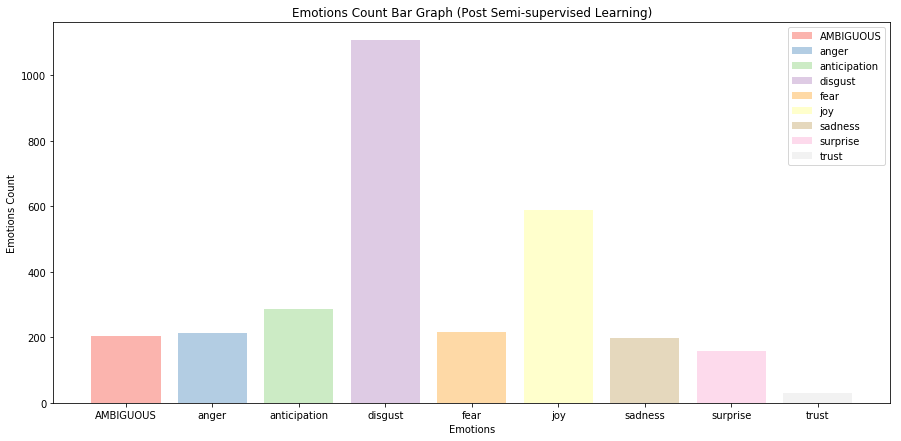

In [144]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=emotions_list)
axes.legend(barlist, emotions_list)
title = "Emotions Count Bar Graph (Post Semi-supervised Learning)"
axes.set_title(title)
axes.set_xlabel("Emotions")
axes.set_ylabel("Emotions Count")
fig.set_size_inches(15, 7)
fig.savefig(title+".png")

#### Comparison check if all newly made labeled set is the same with the base labeled set

In [145]:
emotions_o = emotions.copy()
emotions_o['emotion'] = "" 
df = pd.concat([emotions_o, emotions_c])
df = df.reset_index(drop=True)
df_gpby = df.groupby(list(df.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
df.reindex(idx)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion


In [146]:
# y_pred_rfc_labeled = rfc.predict(X_labeled)
# type(y_pred_rfc_labeled)
# y_pred_rfc_labeled
# accuracy_score(np.array(y_labeled), y_pred_rfc_labeled)

In [147]:
# y_test = y_labeled.copy()
# y_test[0] = np.nan
# for x in range(len())

#### Define data X and target y for emotions data

In [148]:
X = emotions.drop('emotion', axis=1)
y = emotions['emotion']

#### Split the dataset into training and testing set

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Build final model from labeled data and show essential scores to evaluate the model

In [150]:
final_param_grid = {'n_estimators' : [100, 200, 500],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}
final_start_time = datetime.datetime.now()
delayPrint("Start time: {}".format(final_start_time), PRINT_SECONDS)
final_model_file = "final_ssl_rf_{}.pickle".format(threshold*100)
final_gs_file = "final_gs_rf_{}.pickle".format(threshold*100)
final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid)
if isfile(final_model_file) and isfile(final_gs_file):
    delayPrint("Loading final rfc model...", PRINT_SECONDS)
    final_rfc = pickle.load(open(final_model_file, 'rb'))
    delayPrint("Loading final grid search model...", PRINT_SECONDS)
    final_grid_search = pickle.load(open(final_gs_file, 'rb'))
else:
    final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid, cv=10)
    final_grid_search.fit(X_train, y_train)
    final_best_params = final_grid_search.best_params_
    final_rfc = RandomForestClassifier()
    final_rfc.set_params(**final_best_params)
    final_rfc.fit(X_train, y_train)
final_elapsed_time = datetime.datetime.now() - final_start_time
final_rfc_log_file = "final_rfc_clf.log"
delayPrint("Elapsed time: {}".format(final_elapsed_time), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Test set score: {:.2f}".format(final_grid_search.score(X_test, y_test)), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Best parameters: {}".format(final_grid_search.best_params_), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Best cross-validation score: {:.2f}".format(final_grid_search.best_score_), PRINT_SECONDS, final_rfc_log_file)

# save final models
if not isfile(final_model_file) or not isfile(final_gs_file):
    with open(final_model_file, 'wb') as file:
        delayPrint("Saving final rfc model...", PRINT_SECONDS)
        pickle.dump(final_rfc, file)
    with open(final_gs_file, 'wb') as file:
        delayPrint("Saving final grid search model...", PRINT_SECONDS)
        pickle.dump(final_grid_search, file)

Start time: 2018-09-27 15:59:29.499406
Loading final rfc model...
Loading final grid search model...
Elapsed time: 0:00:00.050144
Test set score: 0.64
Best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.64


#### 10 Standard cross-fold validation

In [151]:
scores = cross_val_score(final_rfc, X, y, cv=10)
# scores
print("10 standard cross-fold validation mean score: {}".format(np.mean(scores)))

10 standard cross-fold validation mean score: 0.630157053791339


#### Visualization of trees

In [152]:
# import graphviz
# from sklearn.tree import export_graphviz
# y = y.astype(np.str)
# tree_path = "trees/emotions_tree{}.dot"
# # export all the trees
# for x in range(len(final_rfc.estimators_)):
#     estimator = final_rfc.estimators_[x]
#     export_graphviz(
#             estimator,
#             out_file=tree_path.format(x),
#             feature_names=X.columns,
#             class_names=y.unique(),
#             rounded=True,
#             filled=True
#         )

# with open("trees/emotions_tree0.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

#### Convert all .dots to .pngs

In [153]:
# import pydot
# for x in range(len(final_rfc.estimators_)):
#     (graph,) = pydot.graph_from_dot_file(tree_path.format(x))
#     graph.write_png('trees/emotions_tree{}.png'.format(x))

#### Classification Report

In [154]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
y2 = (y == "disgust")
y3 = cross_val_predict(final_rfc, X, y, cv=10) # y preds for whole dataset
y4 = cross_val_predict(final_rfc, X, y2, cv=10) # binary y
print(classification_report(y, y3, target_names=final_rfc.classes_))

              precision    recall  f1-score   support

   AMBIGUOUS       0.00      0.00      0.00       205
       anger       0.74      0.46      0.57       213
anticipation       0.52      0.66      0.58       285
     disgust       0.74      0.95      0.83      1106
        fear       0.00      0.00      0.00       215
         joy       0.51      0.94      0.66       587
     sadness       0.00      0.00      0.00       199
    surprise       0.00      0.00      0.00       159
       trust       0.00      0.00      0.00        31

 avg / total       0.47      0.63      0.53      3000



/home/butchersix/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Check number of emotions in final classifier

In [155]:
if isfile(final_model_file):
    delayPrint("Loading model...", PRINT_SECONDS)
    final_rfc = pickle.load(open(model_file, 'rb'))
    emotions_list = list(final_rfc.classes_)
    emotions_count_list = []
    for x in emotions_list:
        emotions_count = len(pd.Series(y3).loc[pd.Series(y3) == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count), PRINT_SECONDS)

Loading model...
Number of AMBIGUOUS: 0
Number of anger: 132
Number of anticipation: 359
Number of disgust: 1427
Number of fear: 0
Number of joy: 1082
Number of sadness: 0
Number of surprise: 0
Number of trust: 0


#### Emotions Count Bar Graph (Post Final Class Model)

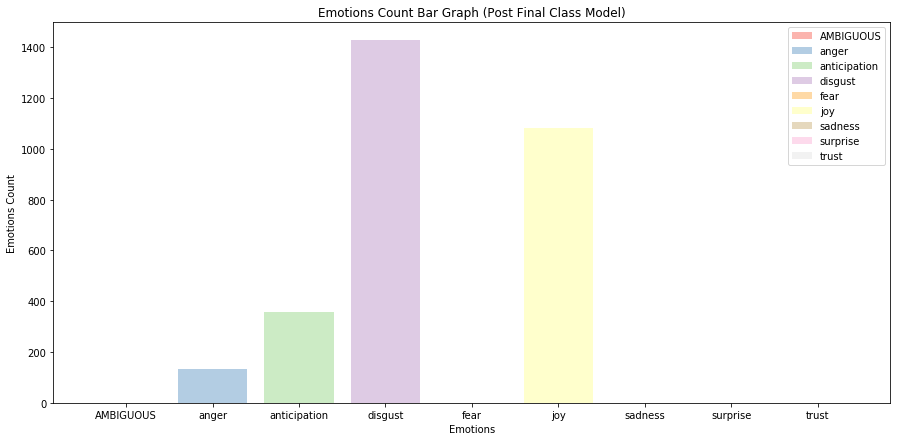

In [156]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=list(final_rfc.classes_))
axes.legend(barlist, emotions_list)
title = "Emotions Count Bar Graph (Post Final Class Model)"
axes.set_title(title)
axes.set_xlabel("Emotions")
axes.set_ylabel("Emotions Count")
fig.set_size_inches(15, 7)
fig.savefig(title+".png")

#### Confusion Matrix

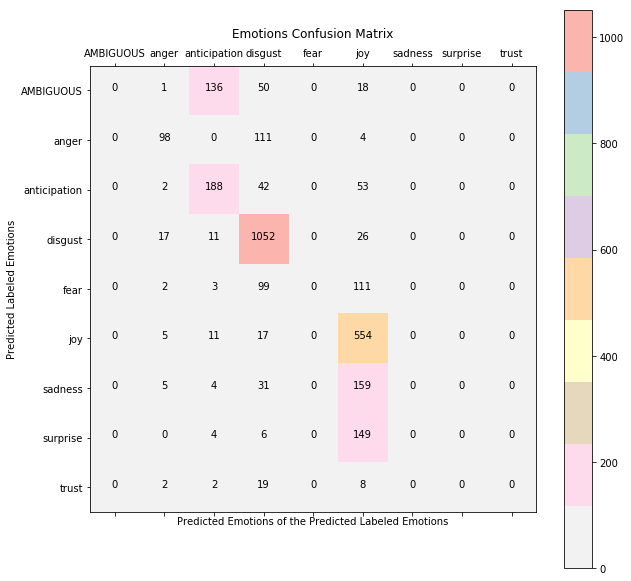

In [157]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y, y3)
plt.matshow(conf_mx, cmap=plt.cm.Pastel1.reversed())
# code for value per box
fmt = 'd'
thresh = conf_mx.max() / 2.
for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
        plt.text(j, i, format(conf_mx[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if conf_mx[i, j] > thresh else "black")
plt.ylabel("Predicted Labeled Emotions")
plt.xlabel("Predicted Emotions of the Predicted Labeled Emotions")
plt.xticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.yticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.colorbar()
plt.gcf().set_size_inches(10,10)
plt.title("Emotions Confusion Matrix")
plt.gcf().savefig("Emotions Confusion Matrix.png")
plt.show()
# fig, axes = plt.figure()
# fig.set_size_inches(30, 20)
# plt.show()

#### Precision vs. Recall

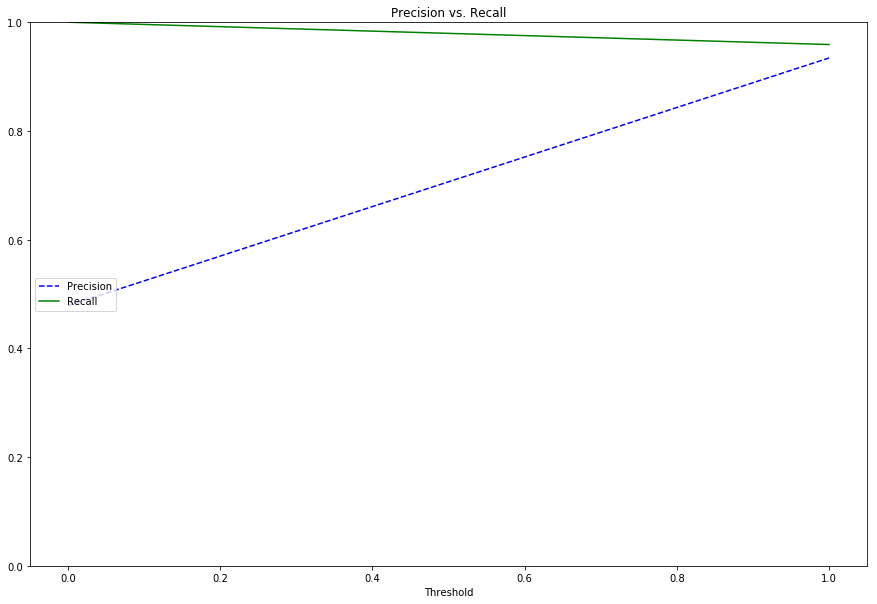

In [158]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(final_rfc, X, y4, cv=10)
precisions, recalls, thresholds = precision_recall_curve(y4, y_scores)

def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.gcf().set_size_inches(15,10)
plt.title("Precision vs. Recall")
plt.gcf().savefig("PrecVsRec.png")
plt.show()

#### Precision against recall

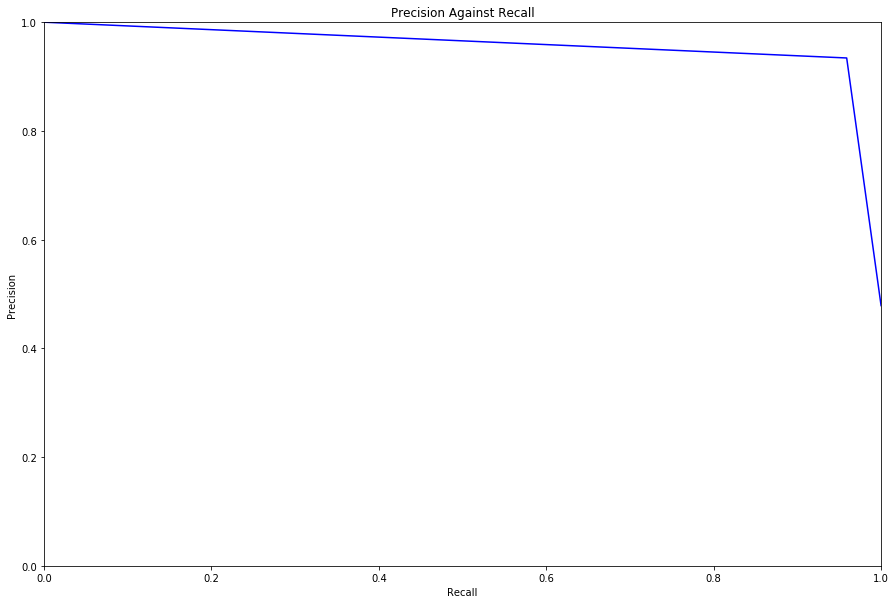

In [159]:
def plot_precision_recall(precisions, recall):
    plt.plot(recall,precisions,"b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0,1])
    plt.ylim([0,1])
    
plot_precision_recall(precisions, recalls)
plt.gcf().set_size_inches(15,10)
plt.title("Precision Against Recall")
plt.gcf().savefig("PrecAgRec.png")
plt.show()

#### ROC Curve

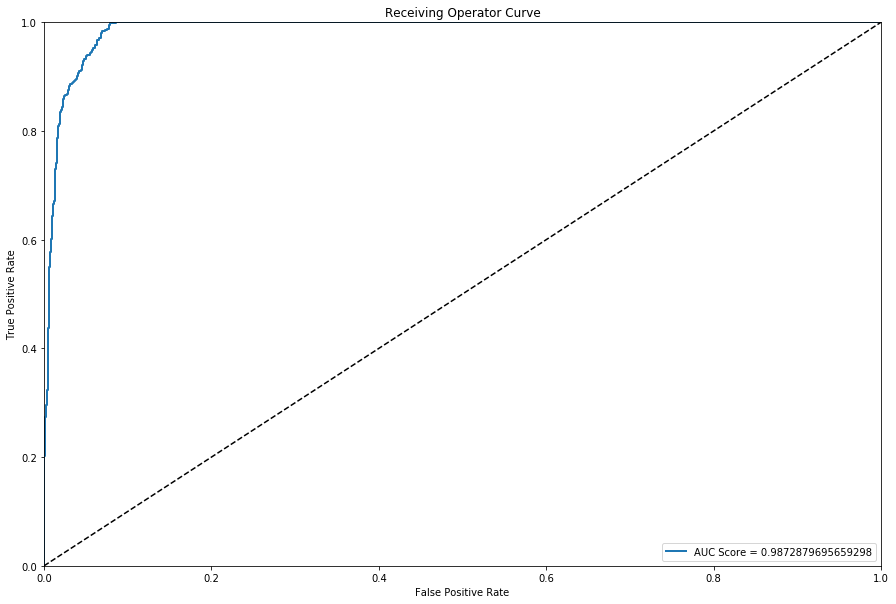

In [160]:
from sklearn.metrics import roc_auc_score
y_probas_forest = cross_val_predict(final_rfc, X, y4, cv=10, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y4, y_scores_forest)
auc_score = roc_auc_score(y4, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest, "AUC Score = {}".format(auc_score))
plt.legend(loc="lower right")
plt.gcf().set_size_inches(15,10)
plt.title("Receiving Operator Curve")
plt.gcf().savefig("ROC.png")
plt.show()

#### Iteration Time Graph

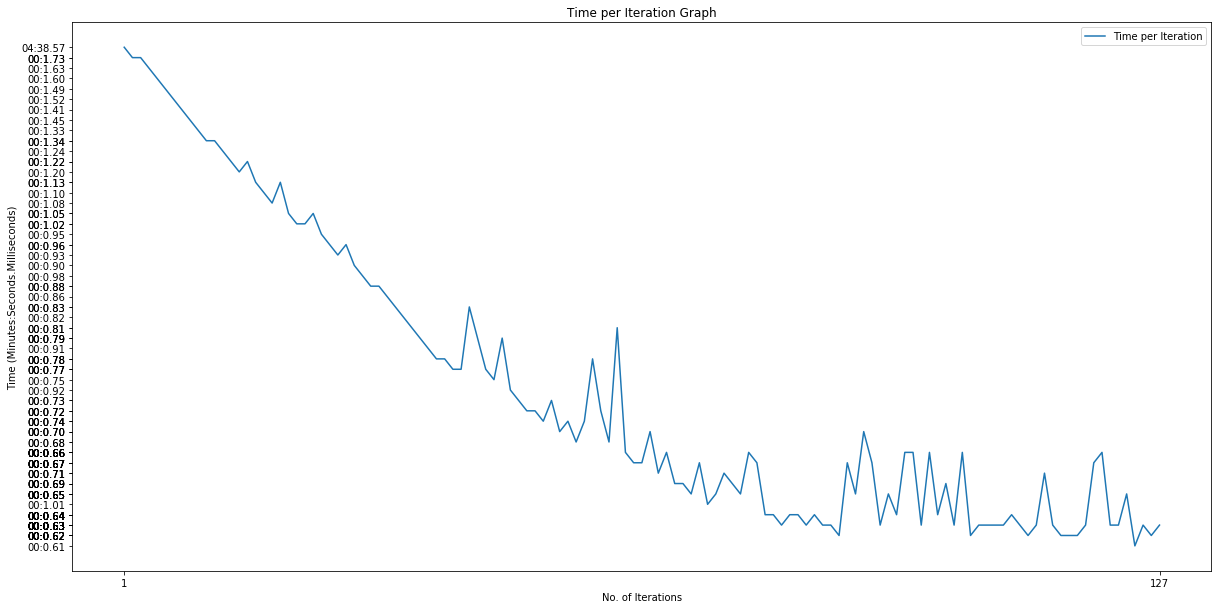

In [161]:
import matplotlib.ticker as ticker
etil = list(map((lambda x: x.split(":")[1]+":"+"{:.2f}".format(float(x.split(":")[2]))), elapsed_time_iter_list))
yticks_etil = []
# for x in range(60):
#     for y in range(60):
#         for z in range(100):
#             yticks_etil.append("{:02d}:{:02d}.{:02d}".format(x, y, z))
#             print("{:02d}:{:02d}.{:02d}".format(x, y, z))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(etil, label="Time per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(etil)
axes.invert_yaxis()
# axes.tick_params(
#     axis='y',
#     left=False,      # ticks along the bottom edge are off
#     labelleft=False) # labels along the bottom edge are off
title = "Time per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Time (Minutes:Seconds.Milliseconds)")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

In [162]:
# X.columns.get_loc('background')
# len(X.values.flatten())

In [163]:
# X_train.values[:, [32, len(X_train.columns) - 1]]

#### Feature importances of final classifier model

In [164]:
for x in range(len(final_rfc.feature_importances_)):
    name = X.columns[x]
    print("{}. {}: {:.5f}".format(x+1, name, final_rfc.feature_importances_[x]))

1. background: 0.19259
2. aeroplane: 0.00000
3. bicycle: 0.00000
4. bird: 0.00842
5. boat: 0.00000
6. bottle: 0.00756
7. bus: 0.00000
8. car: 0.00000
9. cat: 0.00560
10. chair: 0.00248
11. cow: 0.00656
12. diningtable: 0.00000
13. dog: 0.04065
14. horse: 0.03672
15. motorbike: 0.00000
16. person: 0.17853
17. potted plant: 0.00000
18. sheep: 0.00000
19. sofa: 0.00160
20. train: 0.00000
21. tv/monitor: 0.00000
22. red: 0.05448
23. n_red: 0.01863
24. yellow: 0.01732
25. n_yellow: 0.01369
26. green: 0.05474
27. n_green: 0.02355
28. cyan: 0.04772
29. n_cyan: 0.07462
30. blue: 0.03323
31. n_blue: 0.06663
32. magenta: 0.07646
33. n_magenta: 0.03822


#### Decision boundary plotting for each feature

In [165]:
# from mlxtend.plotting import plot_decision_regions
# dict_features = {}
# for x in X_train.columns:
#     if X_train.columns.get_loc(x) > 1:
#         dict_features.update({X_train.columns.get_loc(x) : list(X_train[x])})
# try_rfc_bp = final_rfc.get_params()
# try_rfc = RandomForestClassifier(**try_rfc_bp)
# try_y = pd.Series(list(map((lambda x: list(final_rfc.classes_).index(x)), y_train)))
# for x in X_train.columns:
#     idx = X_train.columns.get_loc(x)
#     try_rfc.fit(X_train.values[:, [idx, len(X_train.columns) - 1]], try_y)
#     fig = plt.figure()
#     axes = plot_decision_regions(X_train.values[:, [idx, len(X_train.columns) - 1]],
#                                  np.array(try_y),
#                                  clf=try_rfc,
#                                  legend=2)
#     fig.set_size_inches(15, 10)
#     rfdb = "Random Forest Decision Boundary"
#     plt.title(rfdb + " Feature {} ({}) Graph".format(idx + 1, x))
#     plt.ylabel("Emotion Class Indices")
#     if x.startswith("n_"):
#         plt.xlabel("No. of Color Instances")
#     else:
#         plt.xlabel("Feature Proportion Value")
#     figfile = "Random Forest Decision Boundaries/" + rfdb + " Feature {} ({}) Graph.png".format(idx + 1, x.replace("/", "or"))
#     if not isfile(figfile):
#         plt.gcf().savefig(figfile)
#     plt.show()

#### Best Test Score Iteration Graph

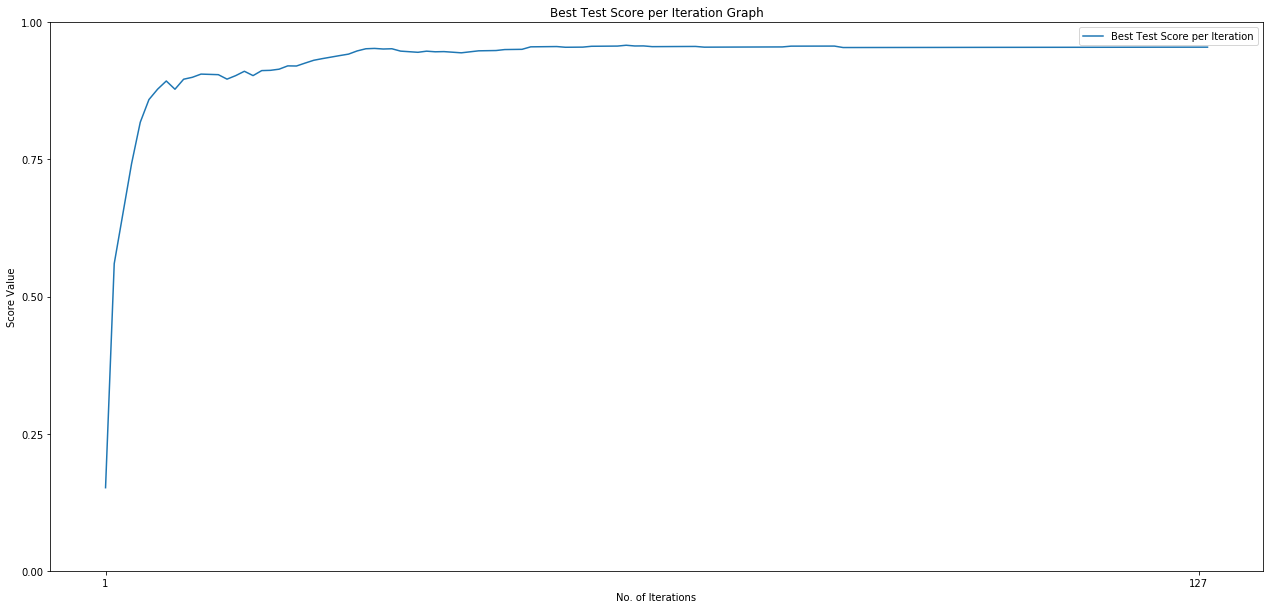

In [166]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(best_score_list, label="Best Test Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Best Test Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

#### Best Cross-validation Scores Graph

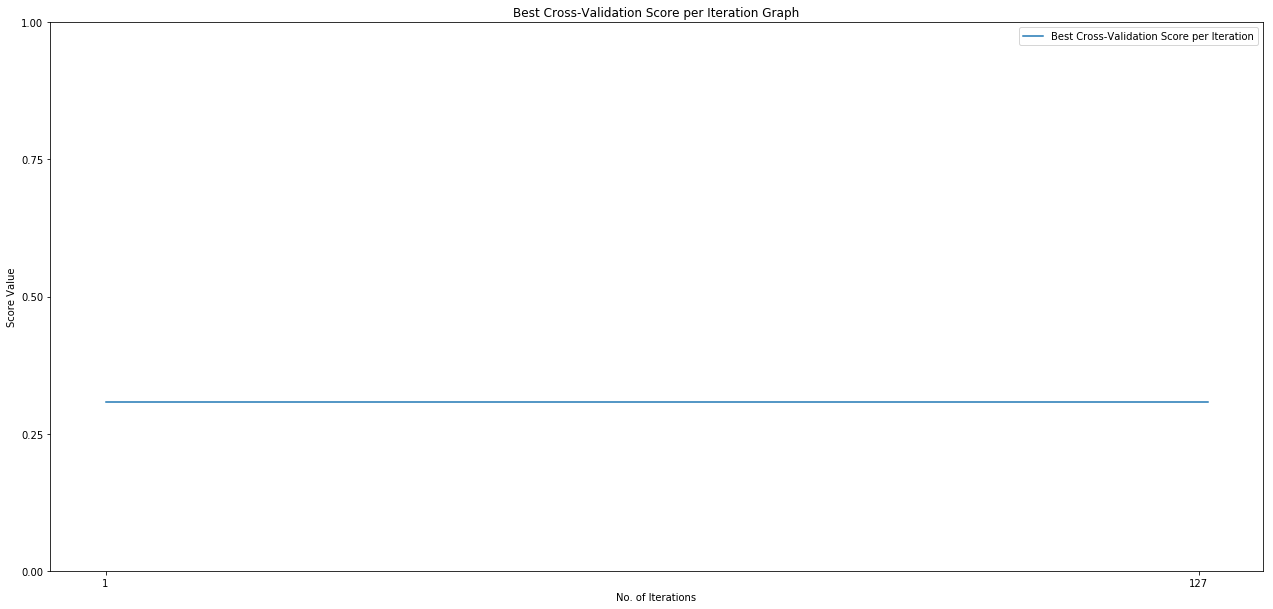

In [167]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(best_cross_val_score, label="Best Cross-Validation Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Best Cross-Validation Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

#### Out-of-Bag Scores Graph

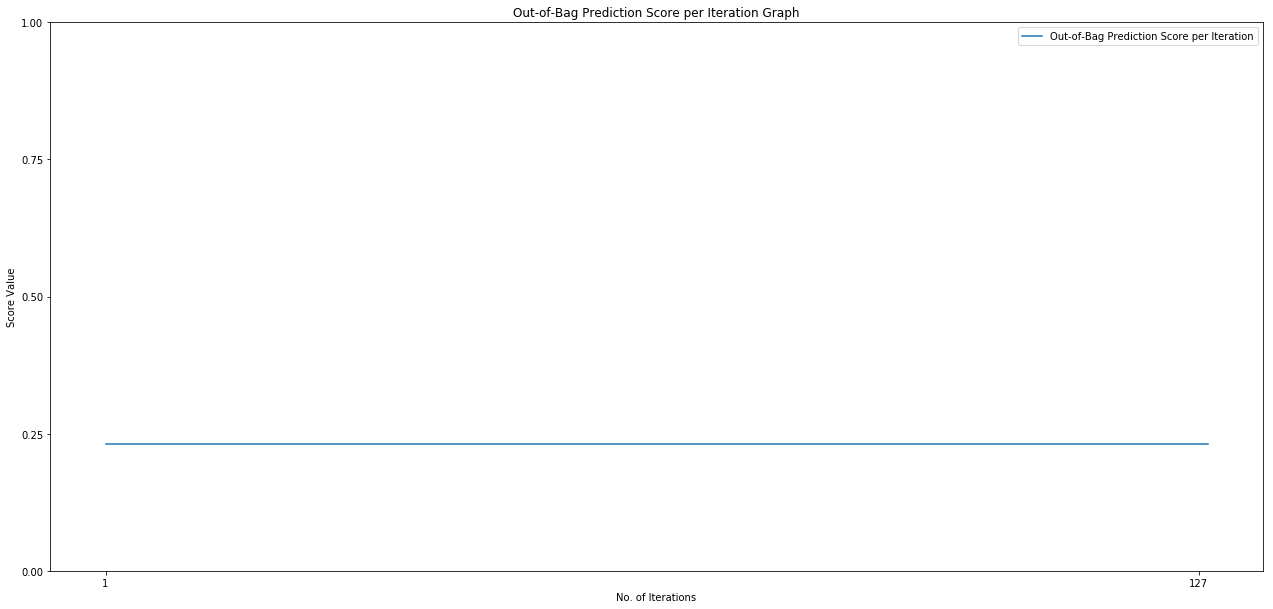

In [168]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(oob_score_list, label="Out-of-Bag Prediction Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Out-of-Bag Prediction Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()